In [15]:
from astropy.io import fits
import numpy as np
import matplotlib.pyplot as plt
import sys
from matplotlib.colors import LogNorm


from photutils.detection import DAOStarFinder
from photutils.detection import IRAFStarFinder

from astropy.stats import mad_std
import time

from lvmtipo.actors import lvm
from lvmagp.focus import Focus


In [16]:
from logging import DEBUG

#from sdsstools.logger import StreamFormatter
#from sdsstools import get_logger, read_yaml_file
#from sdsstools.logger import SDSSLogger

import numpy as np

from astropy.coordinates import SkyCoord, Angle
import astropy.wcs
import astropy.units as u

#from lvmtipo.actors import lvm
from lvmagp.images import Image
from lvmagp.images.processors.detection import DaophotSourceDetection, SepSourceDetection

from scipy.ndimage import median_filter

In [17]:
import asyncio

from cluplus.proxy import invoke

from lvmtipo.actors import lvm
from lvmagp.images import Image
from plotimg import plot_images

from IPython.display import clear_output

In [18]:
from astropy.coordinates import EarthLocation,SkyCoord
from astropy.time import Time
from astropy import units as u
from astropy.coordinates import AltAz,ICRS

import astrometry
solver = astrometry.Solver(
    astrometry.series_5200.index_files(
        cache_directory="astrometry_cache",
        scales={5,6},
    )
)

import spherepoints


In [19]:


import numpy as np
from astropy.io import fits
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm, PowerNorm, SymLogNorm
from matplotlib.patches import Ellipse, Rectangle
from matplotlib import colors


from mpl_toolkits.axes_grid1 import make_axes_locatable


from astropy.visualization import astropy_mpl_style
#plt.style.use(astropy_mpl_style)


ellipse = lambda c: Ellipse(xy=(c['x'], c['y']),
                            width=8*c['a'],
                            height=8*c['b'],
                            angle=c['theta'] * -180. / np.pi)

def plot_catalog(ax, catalog, color="red", cat_max=8, cat_rest=None):
     for c in catalog[:cat_max]:
         e = ellipse(c)
         e.set_facecolor('none')
         e.set_edgecolor(color)
         ax.add_artist(e)
     if cat_rest:
         for c in catalog[cat_max+1:]:
             e = ellipse(c)
             e.set_facecolor('none')
             e.set_edgecolor("white")
             ax.add_artist(e)

def plot_centroid(ax, catalog, color="white"):
     catalog = catalog.transpose()
     for c in catalog:
         e = ellipse({'x': c[0], 'y': c[1], 'a': 8, 'b': 8, 'theta': 0})
         e.set_facecolor('none')
         e.set_edgecolor(color)
         ax.add_artist(e)

def plot_images(images, vmin=None, vmax=None, rotate=None, cat_max = 8, cat_rest = None, cat_extra=None, figsize=None, wcs=None):
    data = images[0].data
    mean, sigma, min, max = np.mean(data), np.std(data), np.min(data), np.max(data)
    lperc, uperc = np.percentile(data, 5), np.percentile(data, 99.5)
    median = np.median(data)

    
    args={}
#    fig, ax = plt.subplots(1, ncols=(len(images)))
#    fig, ax = plt.subplots(1, ncols=(len(images)), dpi=100)
    fig, ax = plt.subplots(1, ncols=(len(images)), figsize=figsize if figsize else (8, 5/len(images)), *args)
#    fig, ax = plt.subplots(nrows=(len(images)), figsize=(16,9))
    
    fig.canvas.toolbar_visible = 'fade-in-fade-out'
#    fig.canvas.footer_visible = False
    fig.canvas.header_visible = False
    fig.canvas.toolbar_position = 'left'
    is_single_image = len(images) > 1


    for idx, img in enumerate(images):
        if rotate and rotate[idx]:
            data = np.copy(img.data).transpose()
        else:
            data = img.data

        ax_idx = ax[idx] if is_single_image else ax
        ax_idx.set_title(img.header["CAMNAME"])
        ax_idx.scatter([img.data.shape[1]/2], [img.data.shape[0]/2], marker='+', s=40, color='red')
#        ax_im = ax_idx.imshow(data,
#                              vmin=vmin if vmin else median,
#                              vmax=vmax if vmax else uperc)
        if wcs: 
            # wcs = WCS(hdu.header)
            print(wcs)

        ax_im = ax_idx.imshow(data,
                              norm=PowerNorm(1.4,
                                             vmin=vmin if vmin else median,
                                             vmax=vmax if vmax else uperc,
                                             clip=True,
                                            )
                             )

        

        ax_idx.invert_yaxis()
        fig.colorbar(ax_im, cax=make_axes_locatable(ax_idx).append_axes('right', size='3%', pad=0.05), orientation='vertical')
      
        if img.catalog:
            plot_catalog(ax_idx, img.catalog, "red", cat_max, cat_rest)

        if cat_extra:
            plot_catalog(ax_idx, cat_extra[idx], "yellow")

        if hasattr(img, "centroid"):
            plot_centroid(ax_idx, img.centroid, "white")

    # plt.scatter(x, y, marker='+', s=40, color='red')

    fig.tight_layout()
    plt.show()
    
from lvmagp.focus.focusseries.base import FocusSeries
from lvmagp.focus.curvefit import fit_hyperbola
from lvmagp.images import Image

import matplotlib.pyplot as plt


def callback(data):
    if isinstance(data[0], Image):
        for idx, img in enumerate(data):
            print(f"cam: {img.header['CAMNAME']} focus: {img.header['FOCUSDT']} srcs: {len(img.catalog)}")
        plot_images(data)
    elif isinstance(data[0], tuple):
        fig, ax = plt.subplots(1, ncols=(len(data)), figsize=(10, 5/len(data)))

        for idx, d in enumerate(data):
            camera = d[0]
            dd = d[1]
            focus = [d["focus"] for d in dd]
            r = [d["r"] for d in dd]
            rerr = [d["rerr"] for d in dd]

            ax_idx = ax[idx] if len(data) > 1 else ax
            ax_idx.set_title(camera)
            ax_idx.errorbar(focus, r, yerr=rerr)

async def foc_series(do_home=False):
    
    if do_home:
        await lvm.skyw.foc.moveToHome()
    
    focvals = await focus.fine(exposure_time=7.0, guess=36.07, count=5, step=0.3, callback=callback)
    print(focvals)
    best_focus_position = np.nanmean(focvals, axis=0)
    print("best focus",np.nanmean(focvals, axis=0))
    if np.isnan(best_focus_position[0]):
        print("no focus found for this field!")
        return
    await focus.position(best_focus_position[0])
    exptime = 5
    rc = await tel.agc.expose( exptime)
    filenames = rc.flatten().unpack("*.filename")
    print("best focus images:", filenames)

    with fits.open(filenames[0]) as hdul:
        data_east = hdul[0].data

    with fits.open(filenames[1]) as hdul:
        data_west = hdul[0].data

    image_list = [data_east,data_west]

    fig,(ax1,ax2) = plt.subplots(figsize=(8,8),ncols=2)
    ax1.imshow(data_east.T,norm=LogNorm(vmin=50, vmax=1000))
    ax2.imshow(data_west.T,norm=LogNorm(vmin=50, vmax=1000))
    fig.suptitle("best focus images")
    plt.show()
    return filenames

async def find_foc(guess=38.5):
    focvals = await focus.fine(exposure_time=10.0, guess=guess, count=5, step=0.1, callback=callback)
    print(focvals)
    best_focus_position = np.nanmean(focvals, axis=0)
    print("best focus",np.nanmean(focvals, axis=0))
    if np.isnan(best_focus_position[0]):
        print("no focus found for this field!")
        return
    await focus.position(best_focus_position[0])
    exptime = 5
    rc = await tel.agc.expose( exptime)
    filenames = rc.flatten().unpack("*.filename")
    print("best focus images:", filenames)

In [20]:
# select telescope
tel = lvm.spec



await tel.start()

focus = Focus(tel)

await tel.foc.status()

{'Reachable': True,
 'AtHome': False,
 'Moving': False,
 'PositionSwitchStatus': 0,
 'Position': 38.38,
 'DeviceEncoder': {'Position': -810.0, 'Unit': 'STEPS'},
 'Velocity': 0.0,
 'AtLimit': False}

In [8]:
# points uniform over the sky, minimum altitude 30 degrees

plot = False

alt,az = spherepoints.uniform_points(n=240,minimum_alt=30)

az = az[np.flip(np.argsort(alt))]
alt = alt[np.flip(np.argsort(alt))]

#print(az, alt)
#alt = np.array([0.5*np.pi])
#az = np.array([0])

theta = 0.5*np.pi - alt

r = 1

x = r * np.sin( theta) * np.cos( az )
y = r * np.sin( theta) * np.sin( az )
z = r * np.cos(theta)

if plot:
    fig = plt.figure()
    ax = plt.axes(projection='3d')
    ax.set_box_aspect(aspect=(1,1,1))
    ax.set_xlim(-1,1)
    ax.set_ylim(-1,1)
    ax.set_zlim(-1,1)
    #ax.set_aspect("equal")#
    ax.plot(x,y,z,"ko")

959.9999999999998


In [9]:
# home mount

await tel.pwi.findHome()
await tel.agc.status()


{'east': {'temperature': 39.125,
  'cooler': nan,
  'binning': [1, 1],
  'area': [1600, 1100],
  'state': 'online'}}

In [11]:
#initial pointing for a focus series
_az = 180.
_alt = 80.
current_alt = _alt/180.*np.pi
current_az = _az/180.*np.pi

observing_location = EarthLocation.of_site("Las Campanas Observatory")#(lat='52.2532', lon='351.63910339111703', height=100*u.m)  
observing_time = Time.now()

current_aa = SkyCoord(alt=current_alt*u.rad, az = current_az*u.rad, frame='altaz', obstime=Time.now(), location=observing_location)
    
current_icrs = current_aa.transform_to(ICRS)
print(current_aa)
print(current_icrs)

rc = await tel.pwi.gotoRaDecJ2000(current_icrs.ra.hour,current_icrs.dec.deg)
ra_h, dec_d = rc.flatten().unpack("ra_j2000_hours", "dec_j2000_degs")
print(f"ra_h:dec_d {ra_h}:{dec_d}")

<SkyCoord (AltAz: obstime=2023-03-08 01:19:59.264266, location=(1845655.49905341, -5270856.2947176, -3075330.77760682) m, pressure=0.0 hPa, temperature=0.0 deg_C, relative_humidity=0.0, obswl=1.0 micron): (az, alt) in deg
    (180., 80.)>
<SkyCoord (ICRS): (ra, dec) in deg
    (114.58737538, -38.94750765)>
ra_h:dec_d 7.63916070999416:-38.9475169507602


INFO:lvmagp.focus.focusseries.photometry:Found median radius of 4.0+-0.6.


cam: east focus: 38.0 srcs: 27


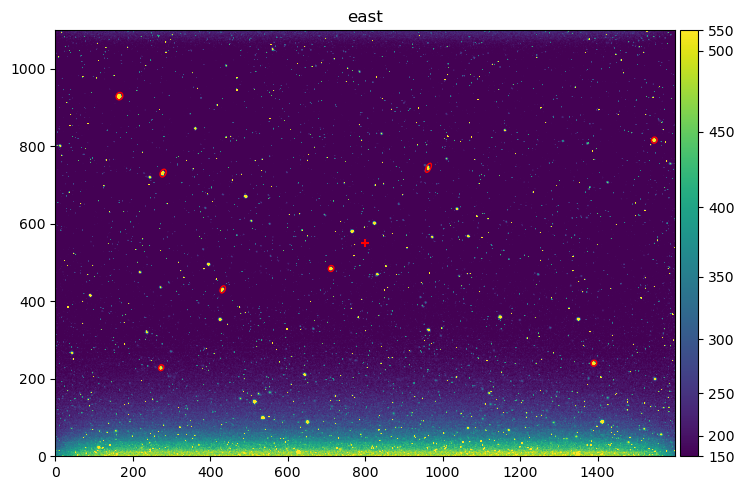

INFO:lvmagp.focus.focusseries.photometry:Found median radius of 4.0+-0.6.


cam: east focus: 38.1 srcs: 27


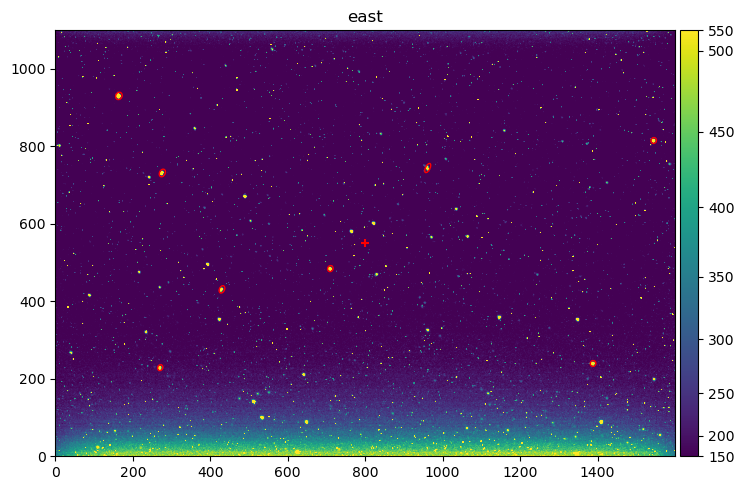

INFO:lvmagp.focus.focusseries.photometry:Found median radius of 3.7+-0.6.


cam: east focus: 38.2 srcs: 26


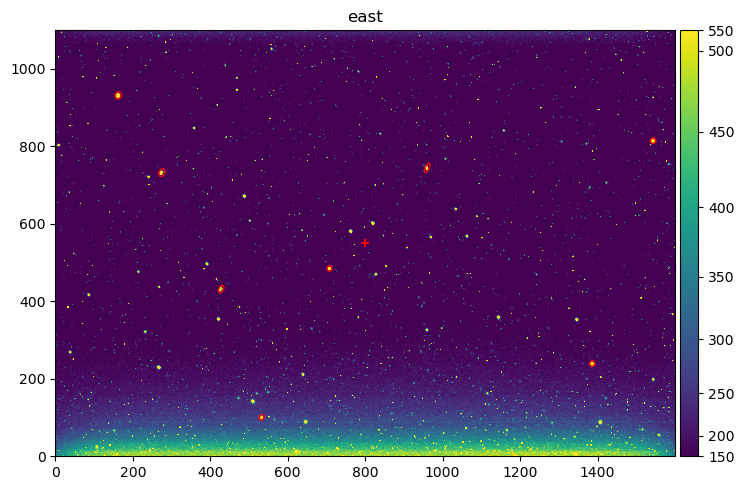

INFO:lvmagp.focus.focusseries.photometry:Found median radius of 3.9+-0.6.


cam: east focus: 38.3 srcs: 24


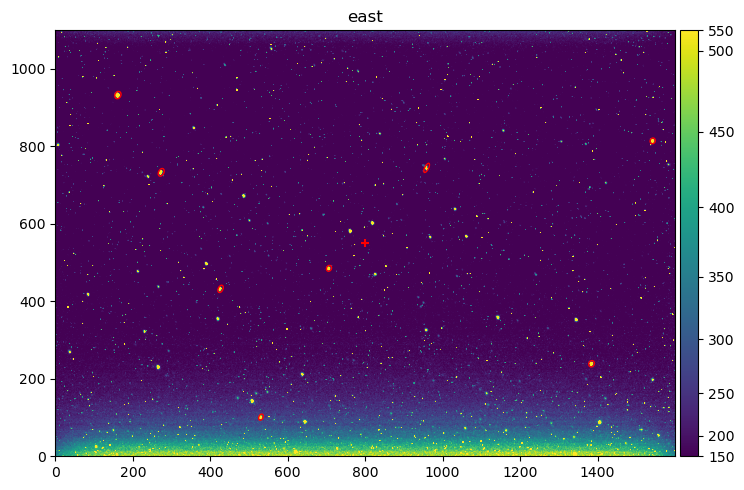

INFO:lvmagp.focus.focusseries.photometry:Found median radius of 3.8+-0.6.


cam: east focus: 38.4 srcs: 23


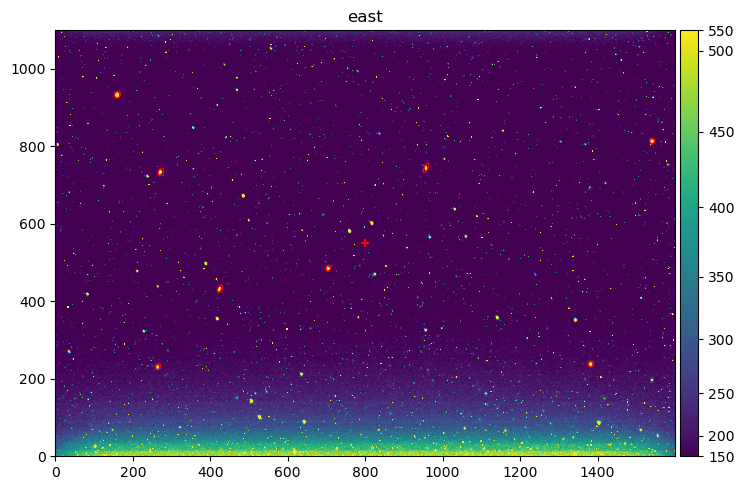

INFO:lvmagp.focus.focusseries.photometry:Found median radius of 3.9+-0.5.


cam: east focus: 38.5 srcs: 21


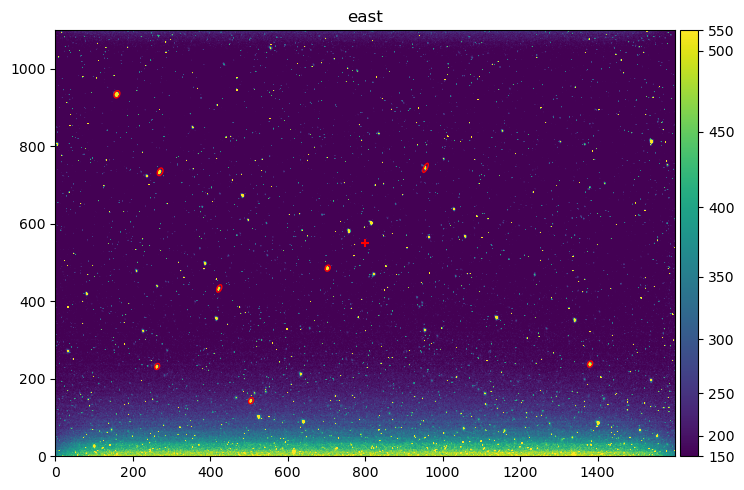

INFO:lvmagp.focus.focusseries.photometry:Found median radius of 4.0+-0.6.


cam: east focus: 38.6 srcs: 21


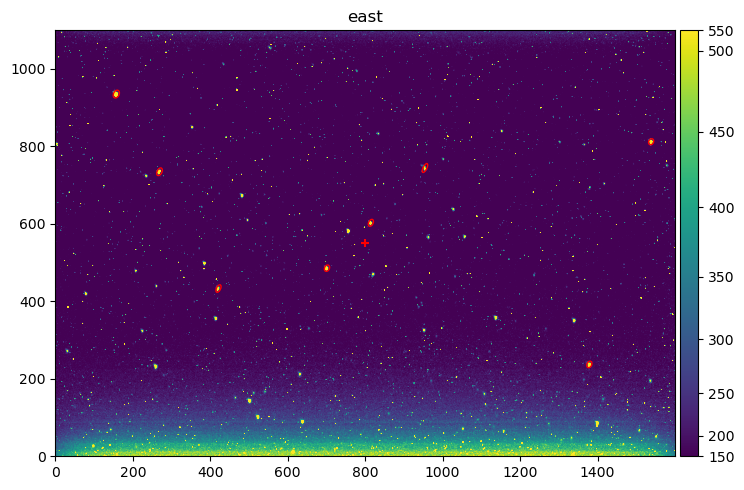

INFO:lvmagp.focus.focusseries.photometry:Found median radius of 3.9+-0.7.


cam: east focus: 38.7 srcs: 21


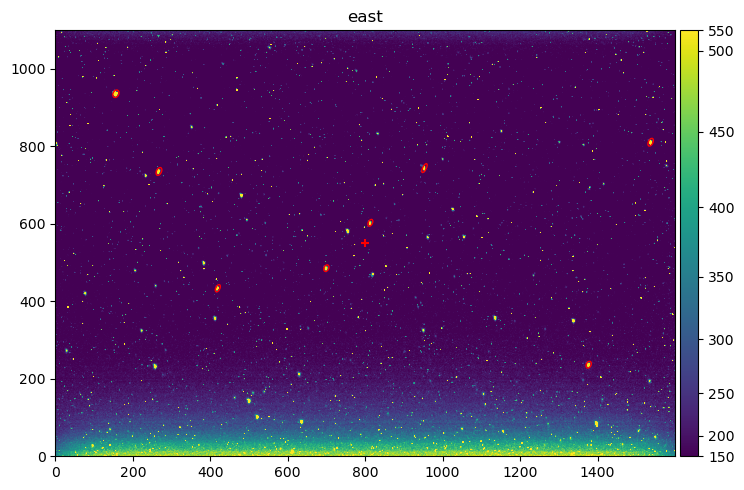

INFO:lvmagp.focus.focusseries.photometry:Found median radius of 4.1+-0.7.


cam: east focus: 38.8 srcs: 20


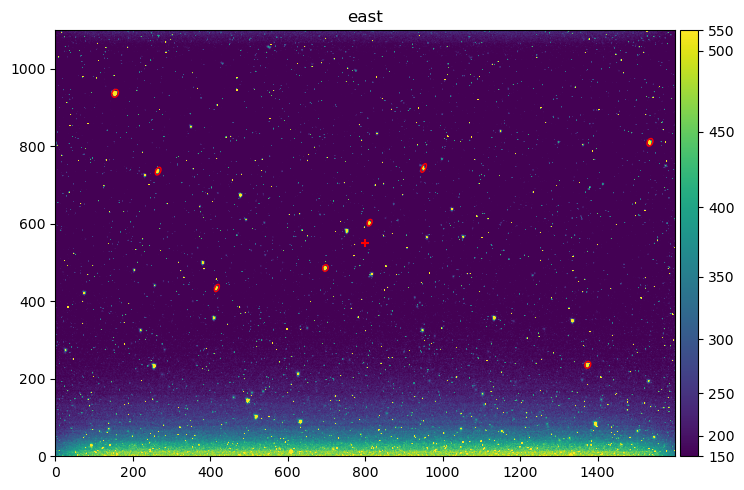

INFO:lvmagp.focus.focusseries.photometry:Found median radius of 4.0+-0.7.


cam: east focus: 38.9 srcs: 21


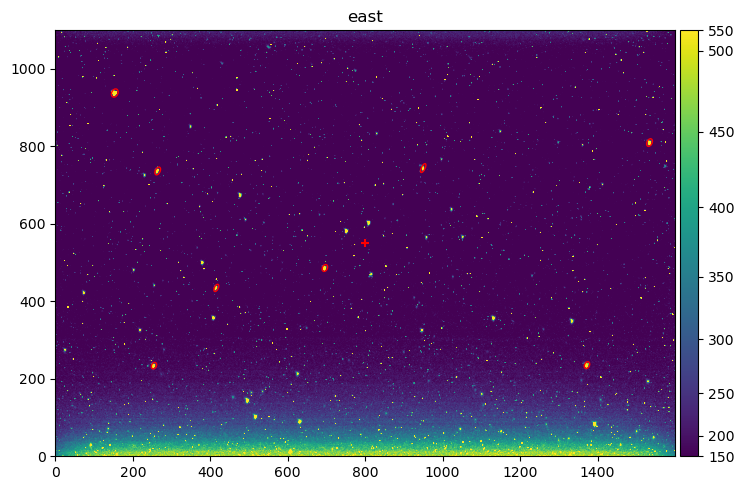

INFO:lvmagp.focus.focusseries.photometry:Found median radius of 4.4+-0.7.


cam: east focus: 39.0 srcs: 20


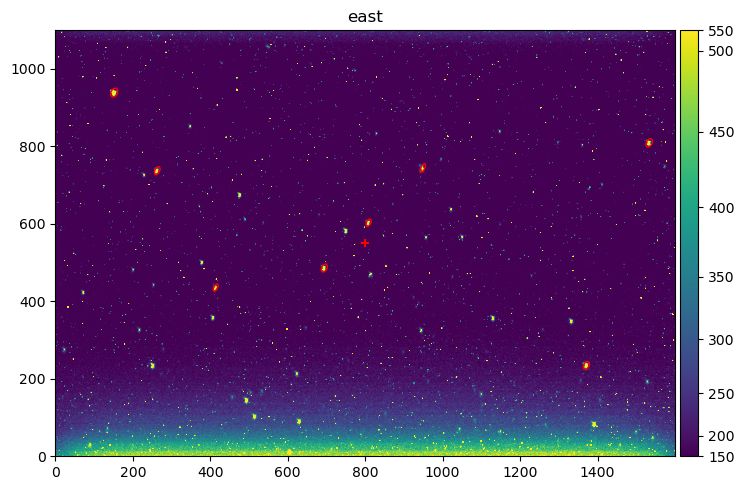

DEBUG:lvm_tel_focus:foc move to position 38.37854580633884 dt


[[3.83785458e+01 1.92180431e-03]]
best focus [3.83785458e+01 1.92180431e-03]
best focus images: /data/lvm/spec/agcam/east/20230308/lvm.spec.agcam.east_00000036.fits


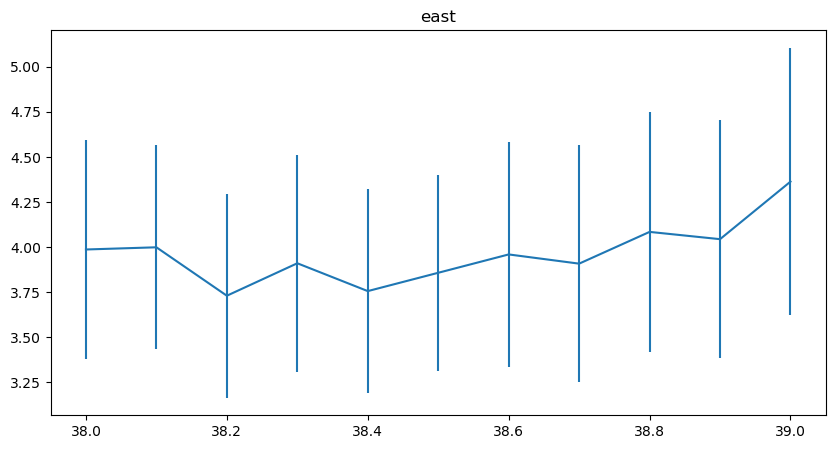

In [16]:
# do focus series

await find_foc(guess=38.5)

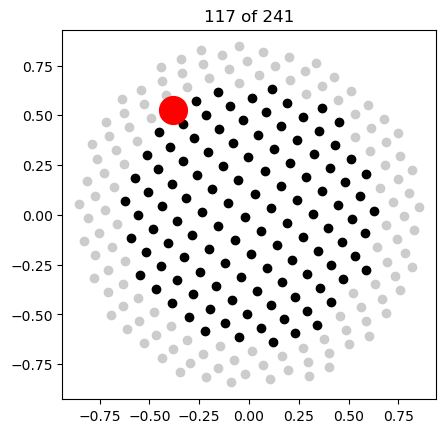

0.8601657354732124 2.196647761365219
<SkyCoord (AltAz: obstime=2023-03-08 01:21:20.011636, location=(1845655.49905341, -5270856.2947176, -3075330.77760682) m, pressure=0.0 hPa, temperature=0.0 deg_C, relative_humidity=0.0, obswl=1.0 micron): (az, alt) in deg
    (125.8586458, 49.28386632)>
<SkyCoord (ICRS): (ra, dec) in deg
    (162.77009972, -44.43982344)>
ra_h:dec_d 10.8513519139635:-44.4399382252604
/data/lvm/spec/agcam/east/20230308/lvm.spec.agcam.east_00000154.fits
---------------------------------


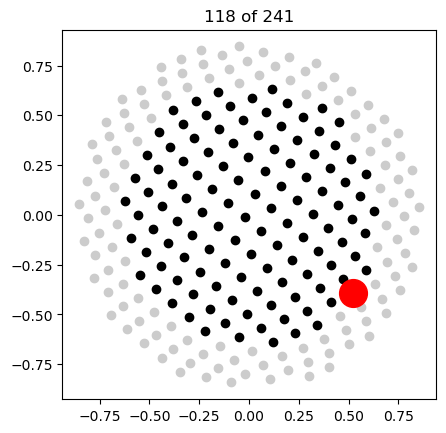

0.8555202518800958 -0.642781444677114
<SkyCoord (AltAz: obstime=2023-03-08 01:21:35.015018, location=(1845655.49905341, -5270856.2947176, -3075330.77760682) m, pressure=0.0 hPa, temperature=0.0 deg_C, relative_humidity=0.0, obswl=1.0 micron): (az, alt) in deg
    (323.17133607, 49.01769972)>
<SkyCoord (ICRS): (ra, dec) in deg
    (91.62798007, 5.34465782)>
ra_h:dec_d 6.10853753137588:5.34475307900496
/data/lvm/spec/agcam/east/20230308/lvm.spec.agcam.east_00000155.fits
---------------------------------


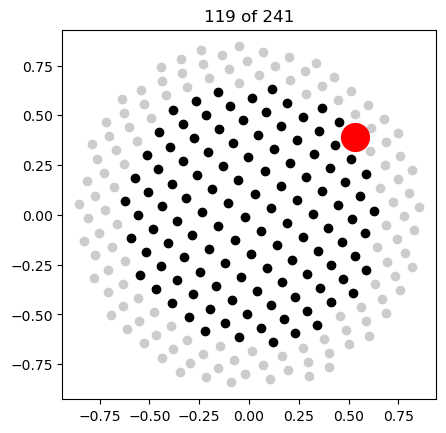

0.8495429458165024 0.6376870121014917
<SkyCoord (AltAz: obstime=2023-03-08 01:21:51.206784, location=(1845655.49905341, -5270856.2947176, -3075330.77760682) m, pressure=0.0 hPa, temperature=0.0 deg_C, relative_humidity=0.0, obswl=1.0 micron): (az, alt) in deg
    (36.53677444, 48.67522531)>
<SkyCoord (ICRS): (ra, dec) in deg
    (138.22296992, 5.82964082)>
ra_h:dec_d 9.21486429655678:5.82963740425366
/data/lvm/spec/agcam/east/20230308/lvm.spec.agcam.east_00000156.fits
---------------------------------


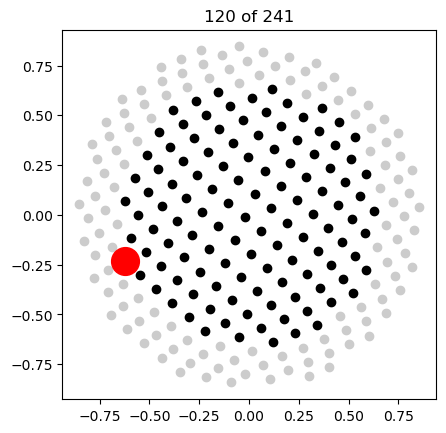

0.8480355574615899 -2.785734661306835
<SkyCoord (AltAz: obstime=2023-03-08 01:22:07.025960, location=(1845655.49905341, -5270856.2947176, -3075330.77760682) m, pressure=0.0 hPa, temperature=0.0 deg_C, relative_humidity=0.0, obswl=1.0 micron): (az, alt) in deg
    (200.38916106, 48.58885832)>
<SkyCoord (ICRS): (ra, dec) in deg
    (82.33289245, -64.95786859)>
ra_h:dec_d 5.48885991361407:-64.9578471560622
/data/lvm/spec/agcam/east/20230308/lvm.spec.agcam.east_00000157.fits
---------------------------------


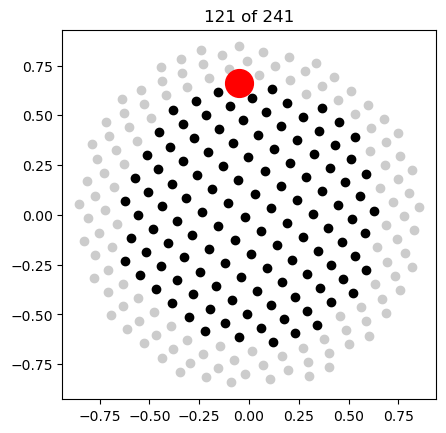

0.8474407377205907 1.6454002757807613
<SkyCoord (AltAz: obstime=2023-03-08 01:22:23.537002, location=(1845655.49905341, -5270856.2947176, -3075330.77760682) m, pressure=0.0 hPa, temperature=0.0 deg_C, relative_humidity=0.0, obswl=1.0 micron): (az, alt) in deg
    (94.27449141, 48.55477766)>
<SkyCoord (ICRS): (ra, dec) in deg
    (161.37231916, -23.86818368)>
ra_h:dec_d 10.7581560591389:-23.8681711135908
/data/lvm/spec/agcam/east/20230308/lvm.spec.agcam.east_00000158.fits
---------------------------------


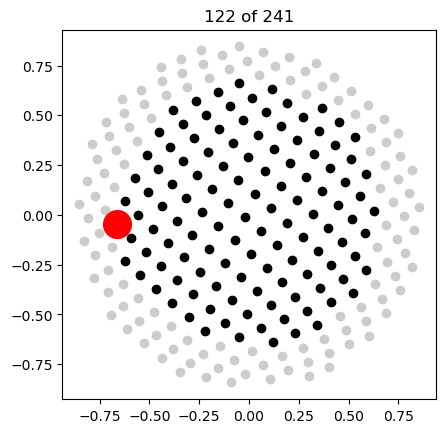

0.8472677641052527 -3.073812497606561
<SkyCoord (AltAz: obstime=2023-03-08 01:22:39.493711, location=(1845655.49905341, -5270856.2947176, -3075330.77760682) m, pressure=0.0 hPa, temperature=0.0 deg_C, relative_humidity=0.0, obswl=1.0 micron): (az, alt) in deg
    (183.88351687, 48.544867)>
<SkyCoord (ICRS): (ra, dec) in deg
    (107.87978486, -70.18980406)>
ra_h:dec_d 7.1919934269149:-70.1897659591366
/data/lvm/spec/agcam/east/20230308/lvm.spec.agcam.east_00000159.fits
---------------------------------


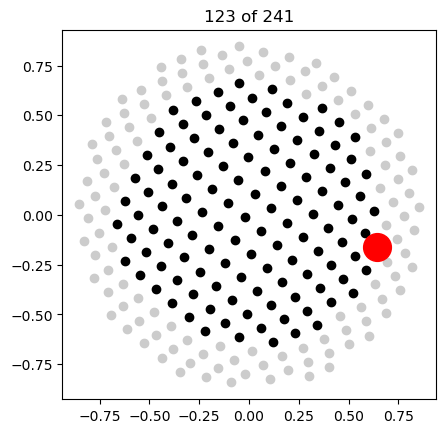

0.845448439028942 -0.24935511817673664
<SkyCoord (AltAz: obstime=2023-03-08 01:22:54.889690, location=(1845655.49905341, -5270856.2947176, -3075330.77760682) m, pressure=0.0 hPa, temperature=0.0 deg_C, relative_humidity=0.0, obswl=1.0 micron): (az, alt) in deg
    (345.71300413, 48.44062735)>
<SkyCoord (ICRS): (ra, dec) in deg
    (105.58526765, 11.53874678)>
ra_h:dec_d 7.03901828362272:11.5387214206151
/data/lvm/spec/agcam/east/20230308/lvm.spec.agcam.east_00000160.fits
---------------------------------


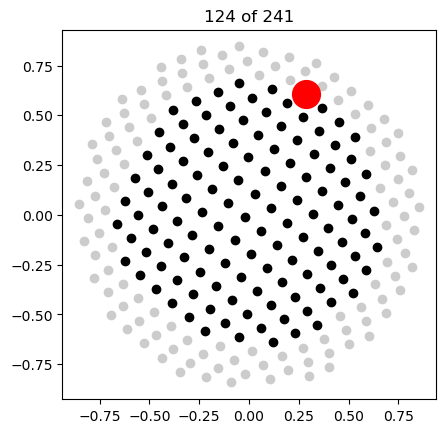

0.8369174418355266 1.1303668129468
<SkyCoord (AltAz: obstime=2023-03-08 01:23:12.132591, location=(1845655.49905341, -5270856.2947176, -3075330.77760682) m, pressure=0.0 hPa, temperature=0.0 deg_C, relative_humidity=0.0, obswl=1.0 micron): (az, alt) in deg
    (64.76524768, 47.95183722)>
<SkyCoord (ICRS): (ra, dec) in deg
    (152.86186455, -6.218455)>
ra_h:dec_d 10.1907926754094:-6.21855328637181
/data/lvm/spec/agcam/east/20230308/lvm.spec.agcam.east_00000161.fits
---------------------------------


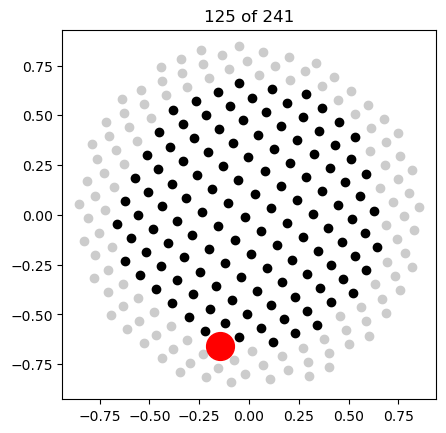

0.8339172167308413 -1.790058422989566
<SkyCoord (AltAz: obstime=2023-03-08 01:23:27.804726, location=(1845655.49905341, -5270856.2947176, -3075330.77760682) m, pressure=0.0 hPa, temperature=0.0 deg_C, relative_humidity=0.0, obswl=1.0 micron): (az, alt) in deg
    (257.43720728, 47.77993698)>
<SkyCoord (ICRS): (ra, dec) in deg
    (66.76451907, -29.1850482)>
ra_h:dec_d 4.45097244530751:-29.1851660130612
/data/lvm/spec/agcam/east/20230308/lvm.spec.agcam.east_00000162.fits
---------------------------------


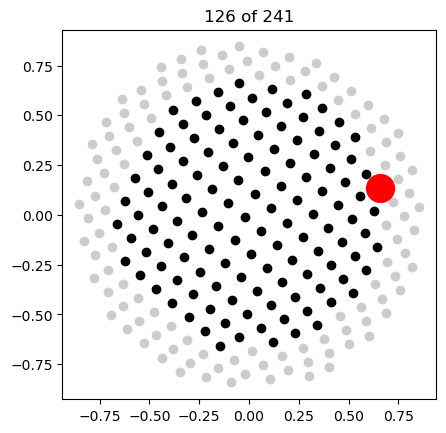

0.8310699351291414 0.20405896992293523
<SkyCoord (AltAz: obstime=2023-03-08 01:23:44.982569, location=(1845655.49905341, -5270856.2947176, -3075330.77760682) m, pressure=0.0 hPa, temperature=0.0 deg_C, relative_humidity=0.0, obswl=1.0 micron): (az, alt) in deg
    (11.69171775, 47.61679976)>
<SkyCoord (ICRS): (ra, dec) in deg
    (123.4597684, 12.73103926)>
ra_h:dec_d 8.23065245835895:12.7309513538423
/data/lvm/spec/agcam/east/20230308/lvm.spec.agcam.east_00000163.fits
---------------------------------


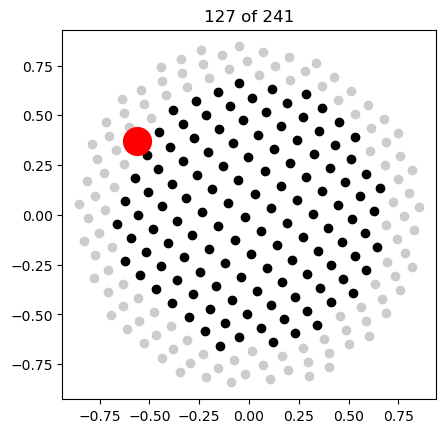

0.8308787222971978 2.5603780915281376
<SkyCoord (AltAz: obstime=2023-03-08 01:24:00.619758, location=(1845655.49905341, -5270856.2947176, -3075330.77760682) m, pressure=0.0 hPa, temperature=0.0 deg_C, relative_humidity=0.0, obswl=1.0 micron): (az, alt) in deg
    (146.6988586, 47.60584407)>
<SkyCoord (ICRS): (ra, dec) in deg
    (160.37456326, -58.19132097)>
ra_h:dec_d 10.691642755883:-58.1912840906596
/data/lvm/spec/agcam/east/20230308/lvm.spec.agcam.east_00000164.fits
---------------------------------


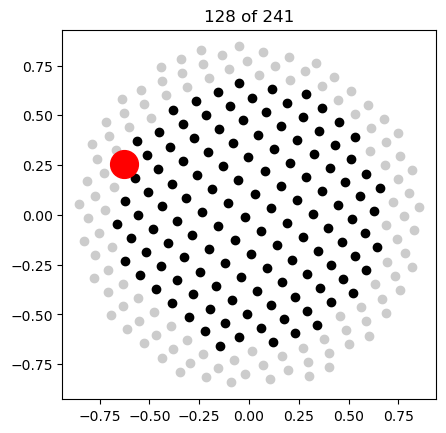

0.8296096164145355 2.75353753742235
<SkyCoord (AltAz: obstime=2023-03-08 01:24:17.502272, location=(1845655.49905341, -5270856.2947176, -3075330.77760682) m, pressure=0.0 hPa, temperature=0.0 deg_C, relative_humidity=0.0, obswl=1.0 micron): (az, alt) in deg
    (157.76607963, 47.53312966)>
<SkyCoord (ICRS): (ra, dec) in deg
    (152.44111085, -64.60838788)>
ra_h:dec_d 10.1627595462128:-64.6084768032871
/data/lvm/spec/agcam/east/20230308/lvm.spec.agcam.east_00000165.fits
---------------------------------


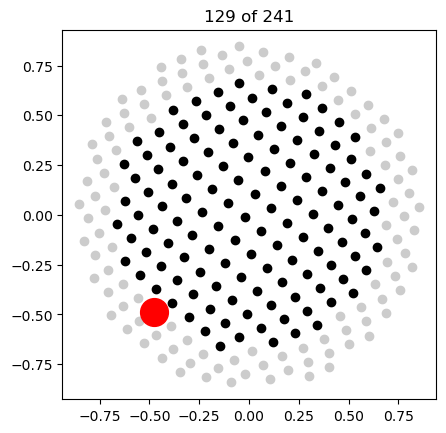

0.8215692608761687 -2.344971933411083
<SkyCoord (AltAz: obstime=2023-03-08 01:24:30.531435, location=(1845655.49905341, -5270856.2947176, -3075330.77760682) m, pressure=0.0 hPa, temperature=0.0 deg_C, relative_humidity=0.0, obswl=1.0 micron): (az, alt) in deg
    (225.64300514, 47.07245123)>
<SkyCoord (ICRS): (ra, dec) in deg
    (65.83497116, -50.53430044)>
ra_h:dec_d 4.38900793173875:-50.5343181756017
/data/lvm/spec/agcam/east/20230308/lvm.spec.agcam.east_00000166.fits
---------------------------------


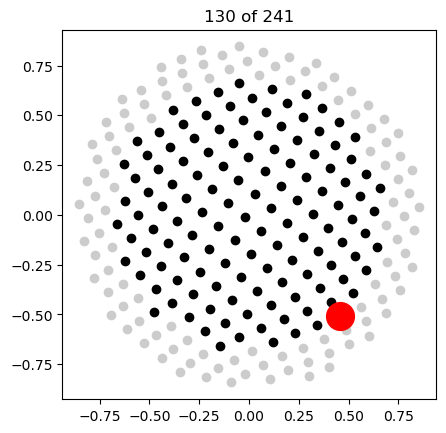

0.820466572728838 -0.8401393021731196
<SkyCoord (AltAz: obstime=2023-03-08 01:24:46.334742, location=(1845655.49905341, -5270856.2947176, -3075330.77760682) m, pressure=0.0 hPa, temperature=0.0 deg_C, relative_humidity=0.0, obswl=1.0 micron): (az, alt) in deg
    (311.86356378, 47.00927185)>
<SkyCoord (ICRS): (ra, dec) in deg
    (85.13934927, 2.47291226)>
ra_h:dec_d 5.67595739737636:2.47292902513553
/data/lvm/spec/agcam/east/20230308/lvm.spec.agcam.east_00000167.fits
---------------------------------


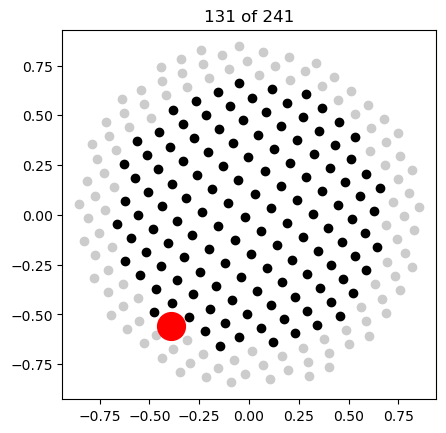

0.8193953870190689 -2.1850554472802006
<SkyCoord (AltAz: obstime=2023-03-08 01:25:02.200962, location=(1845655.49905341, -5270856.2947176, -3075330.77760682) m, pressure=0.0 hPa, temperature=0.0 deg_C, relative_humidity=0.0, obswl=1.0 micron): (az, alt) in deg
    (234.80554487, 46.94789743)>
<SkyCoord (ICRS): (ra, dec) in deg
    (64.66248535, -44.35132055)>
ra_h:dec_d 4.3108339851921:-44.3513117744723
/data/lvm/spec/agcam/east/20230308/lvm.spec.agcam.east_00000168.fits
---------------------------------


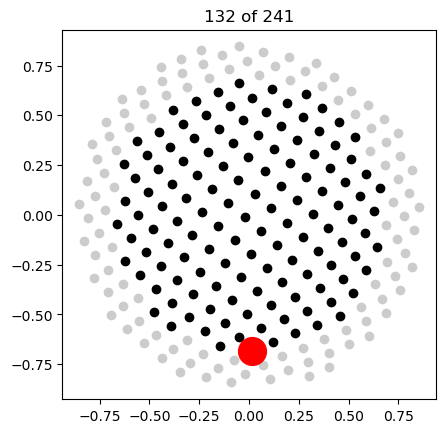

0.8186818678004922 -1.5477620697363197
<SkyCoord (AltAz: obstime=2023-03-08 01:25:17.786298, location=(1845655.49905341, -5270856.2947176, -3075330.77760682) m, pressure=0.0 hPa, temperature=0.0 deg_C, relative_humidity=0.0, obswl=1.0 micron): (az, alt) in deg
    (271.31976571, 46.90701579)>
<SkyCoord (ICRS): (ra, dec) in deg
    (69.28971153, -19.93858248)>
ra_h:dec_d 4.61931331546303:-19.9385165227881
/data/lvm/spec/agcam/east/20230308/lvm.spec.agcam.east_00000169.fits
---------------------------------


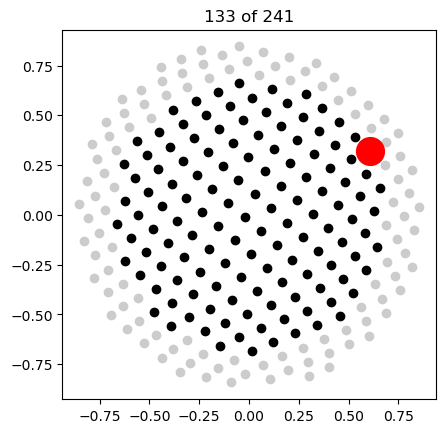

0.8116695715599563 0.4871771218543666
<SkyCoord (AltAz: obstime=2023-03-08 01:25:32.035353, location=(1845655.49905341, -5270856.2947176, -3075330.77760682) m, pressure=0.0 hPa, temperature=0.0 deg_C, relative_humidity=0.0, obswl=1.0 micron): (az, alt) in deg
    (27.91319296, 46.50524081)>
<SkyCoord (ICRS): (ra, dec) in deg
    (134.9872527, 10.47239618)>
ra_h:dec_d 8.99914936765664:10.4723852207925
/data/lvm/spec/agcam/east/20230308/lvm.spec.agcam.east_00000170.fits
---------------------------------


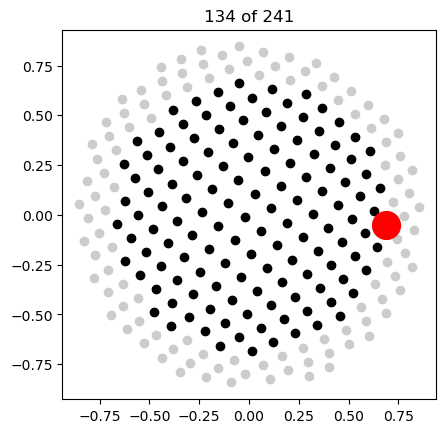

0.8086642852905273 -0.07103997032874011
<SkyCoord (AltAz: obstime=2023-03-08 01:25:48.500299, location=(1845655.49905341, -5270856.2947176, -3075330.77760682) m, pressure=0.0 hPa, temperature=0.0 deg_C, relative_humidity=0.0, obswl=1.0 micron): (az, alt) in deg
    (355.92970952, 46.33305059)>
<SkyCoord (ICRS): (ra, dec) in deg
    (113.01919527, 14.62296711)>
ra_h:dec_d 7.53461828969231:14.622894993185
/data/lvm/spec/agcam/east/20230308/lvm.spec.agcam.east_00000171.fits
---------------------------------


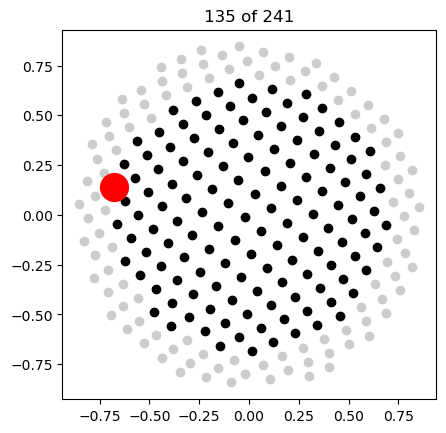

0.806289708313007 2.936789912606274
<SkyCoord (AltAz: obstime=2023-03-08 01:26:03.010029, location=(1845655.49905341, -5270856.2947176, -3075330.77760682) m, pressure=0.0 hPa, temperature=0.0 deg_C, relative_humidity=0.0, obswl=1.0 micron): (az, alt) in deg
    (168.26566731, 46.19699735)>
<SkyCoord (ICRS): (ra, dec) in deg
    (141.17955259, -70.4018892)>
ra_h:dec_d 9.41197733965751:-70.4018857566648
/data/lvm/spec/agcam/east/20230308/lvm.spec.agcam.east_00000172.fits
---------------------------------


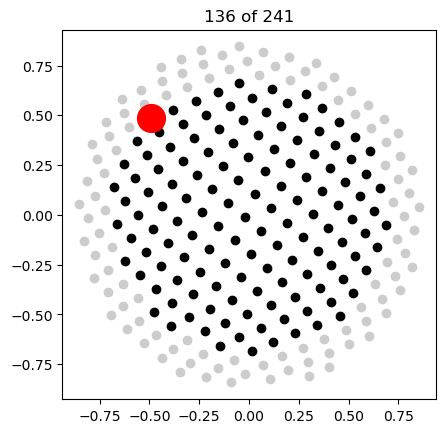

0.8059307495424803 2.365847134888498
<SkyCoord (AltAz: obstime=2023-03-08 01:26:20.337708, location=(1845655.49905341, -5270856.2947176, -3075330.77760682) m, pressure=0.0 hPa, temperature=0.0 deg_C, relative_humidity=0.0, obswl=1.0 micron): (az, alt) in deg
    (135.5530558, 46.17643053)>
<SkyCoord (ICRS): (ra, dec) in deg
    (167.21365697, -51.33260197)>
ra_h:dec_d 11.1475770033341:-51.3325864396148
/data/lvm/spec/agcam/east/20230308/lvm.spec.agcam.east_00000173.fits
---------------------------------


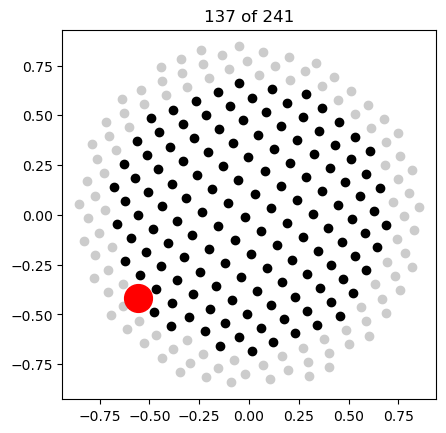

0.8020635064785394 -2.500025812715695
<SkyCoord (AltAz: obstime=2023-03-08 01:26:34.614488, location=(1845655.49905341, -5270856.2947176, -3075330.77760682) m, pressure=0.0 hPa, temperature=0.0 deg_C, relative_humidity=0.0, obswl=1.0 micron): (az, alt) in deg
    (216.75907226, 45.95485382)>
<SkyCoord (ICRS): (ra, dec) in deg
    (67.08553496, -56.72950474)>
ra_h:dec_d 4.47237332327818:-56.7296038369303
/data/lvm/spec/agcam/east/20230308/lvm.spec.agcam.east_00000174.fits
---------------------------------


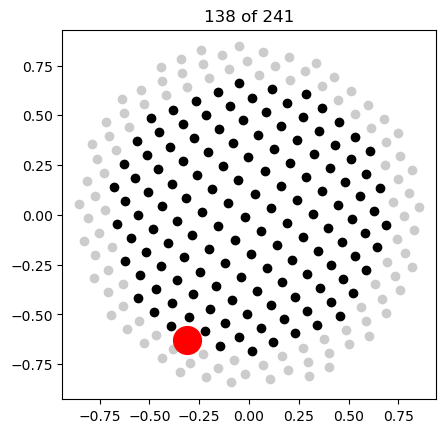

0.793404347802674 -2.0299343209523077
<SkyCoord (AltAz: obstime=2023-03-08 01:26:50.920004, location=(1845655.49905341, -5270856.2947176, -3075330.77760682) m, pressure=0.0 hPa, temperature=0.0 deg_C, relative_humidity=0.0, obswl=1.0 micron): (az, alt) in deg
    (243.69333072, 45.45872058)>
<SkyCoord (ICRS): (ra, dec) in deg
    (63.23877212, -38.18464129)>
ra_h:dec_d 4.21592187649166:-38.1846569535841
/data/lvm/spec/agcam/east/20230308/lvm.spec.agcam.east_00000175.fits
---------------------------------


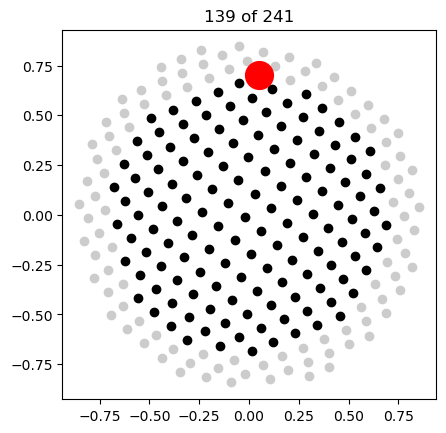

0.78765056253104 1.5023057784251033
<SkyCoord (AltAz: obstime=2023-03-08 01:27:04.603232, location=(1845655.49905341, -5270856.2947176, -3075330.77760682) m, pressure=0.0 hPa, temperature=0.0 deg_C, relative_humidity=0.0, obswl=1.0 micron): (az, alt) in deg
    (86.07578064, 45.12905296)>
<SkyCoord (ICRS): (ra, dec) in deg
    (163.85714817, -17.41660697)>
ra_h:dec_d 10.9238116141035:-17.4166239033188
/data/lvm/spec/agcam/east/20230308/lvm.spec.agcam.east_00000176.fits
---------------------------------


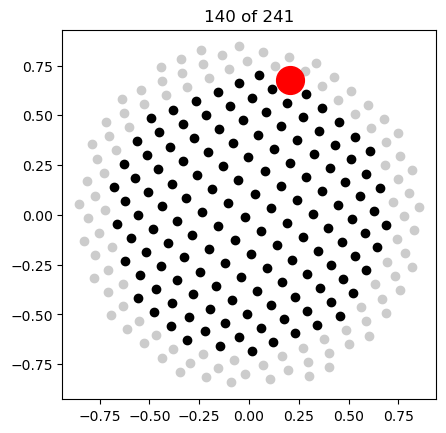

0.7847331511848127 1.2745135833162402
<SkyCoord (AltAz: obstime=2023-03-08 01:27:22.003972, location=(1845655.49905341, -5270856.2947176, -3075330.77760682) m, pressure=0.0 hPa, temperature=0.0 deg_C, relative_humidity=0.0, obswl=1.0 micron): (az, alt) in deg
    (73.02424926, 44.96189761)>
<SkyCoord (ICRS): (ra, dec) in deg
    (159.6473888, -9.19780963)>
ra_h:dec_d 10.6431600542779:-9.19781134529515
/data/lvm/spec/agcam/east/20230308/lvm.spec.agcam.east_00000177.fits
---------------------------------


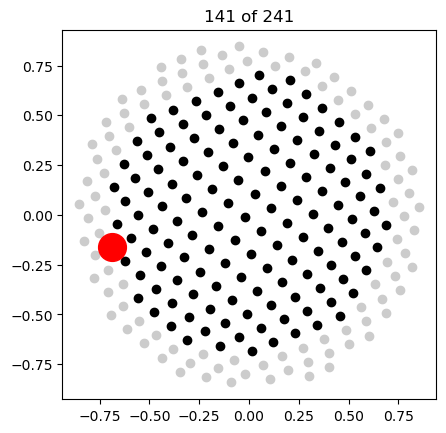

0.784290745497101 -2.9142638430773267
<SkyCoord (AltAz: obstime=2023-03-08 01:27:35.136342, location=(1845655.49905341, -5270856.2947176, -3075330.77760682) m, pressure=0.0 hPa, temperature=0.0 deg_C, relative_humidity=0.0, obswl=1.0 micron): (az, alt) in deg
    (193.0249814, 44.93654963)>
<SkyCoord (ICRS): (ra, dec) in deg
    (87.3875297, -71.02618253)>
ra_h:dec_d 5.82584355962736:-71.0262061619953
/data/lvm/spec/agcam/east/20230308/lvm.spec.agcam.east_00000178.fits
---------------------------------


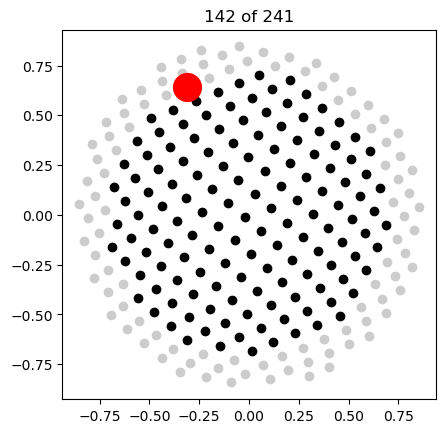

0.7758128563953303 2.0188842452356495
<SkyCoord (AltAz: obstime=2023-03-08 01:27:51.203812, location=(1845655.49905341, -5270856.2947176, -3075330.77760682) m, pressure=0.0 hPa, temperature=0.0 deg_C, relative_humidity=0.0, obswl=1.0 micron): (az, alt) in deg
    (115.67354658, 44.45080236)>
<SkyCoord (ICRS): (ra, dec) in deg
    (170.76718252, -37.46438382)>
ra_h:dec_d 11.3844772072951:-37.4643733178524
/data/lvm/spec/agcam/east/20230308/lvm.spec.agcam.east_00000179.fits
---------------------------------


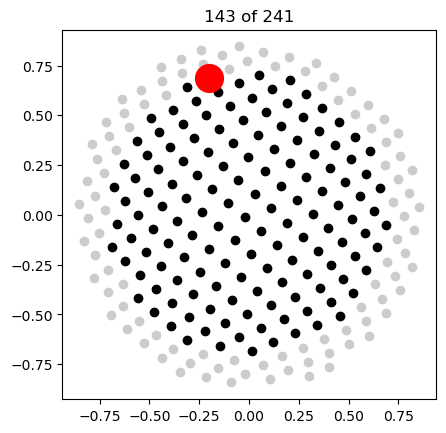

0.772281669113232 1.8570406089659288
<SkyCoord (AltAz: obstime=2023-03-08 01:28:07.035777, location=(1845655.49905341, -5270856.2947176, -3075330.77760682) m, pressure=0.0 hPa, temperature=0.0 deg_C, relative_humidity=0.0, obswl=1.0 micron): (az, alt) in deg
    (106.40058928, 44.24848024)>
<SkyCoord (ICRS): (ra, dec) in deg
    (169.84355423, -30.88426853)>
ra_h:dec_d 11.3229129419263:-30.8843812315589
/data/lvm/spec/agcam/east/20230308/lvm.spec.agcam.east_00000180.fits
---------------------------------


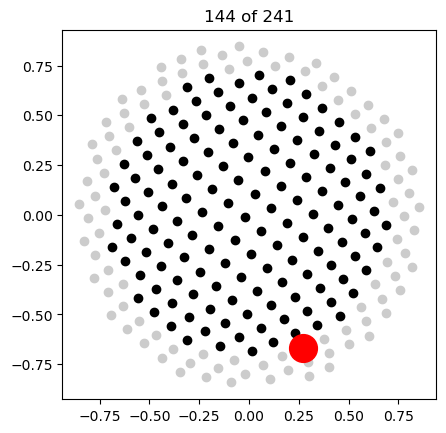

0.7680689046107447 -1.1847460968952894
<SkyCoord (AltAz: obstime=2023-03-08 01:28:20.496246, location=(1845655.49905341, -5270856.2947176, -3075330.77760682) m, pressure=0.0 hPa, temperature=0.0 deg_C, relative_humidity=0.0, obswl=1.0 micron): (az, alt) in deg
    (292.11904885, 44.00710661)>
<SkyCoord (ICRS): (ra, dec) in deg
    (74.56151282, -5.77206661)>
ra_h:dec_d 4.97077523600812:-5.77197583204316
/data/lvm/spec/agcam/east/20230308/lvm.spec.agcam.east_00000181.fits
---------------------------------


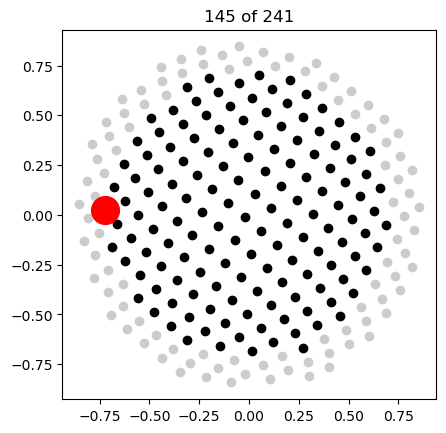

0.7654223498676096 3.105432797310311
<SkyCoord (AltAz: obstime=2023-03-08 01:28:38.109223, location=(1845655.49905341, -5270856.2947176, -3075330.77760682) m, pressure=0.0 hPa, temperature=0.0 deg_C, relative_humidity=0.0, obswl=1.0 micron): (az, alt) in deg
    (177.92819285, 43.85547019)>
<SkyCoord (ICRS): (ra, dec) in deg
    (122.85769623, -74.98441075)>
ra_h:dec_d 8.1905124789193:-74.984320037747
/data/lvm/spec/agcam/east/20230308/lvm.spec.agcam.east_00000182.fits
---------------------------------


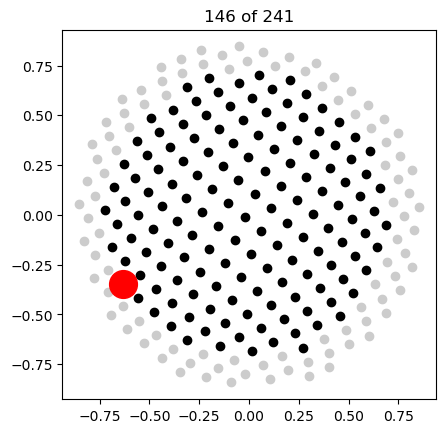

0.7640938593877662 -2.643168056638046
<SkyCoord (AltAz: obstime=2023-03-08 01:28:54.325579, location=(1845655.49905341, -5270856.2947176, -3075330.77760682) m, pressure=0.0 hPa, temperature=0.0 deg_C, relative_humidity=0.0, obswl=1.0 micron): (az, alt) in deg
    (208.55762581, 43.77935329)>
<SkyCoord (ICRS): (ra, dec) in deg
    (67.73595099, -62.93102147)>
ra_h:dec_d 4.51574667345016:-62.9310348030898
/data/lvm/spec/agcam/east/20230308/lvm.spec.agcam.east_00000183.fits
---------------------------------


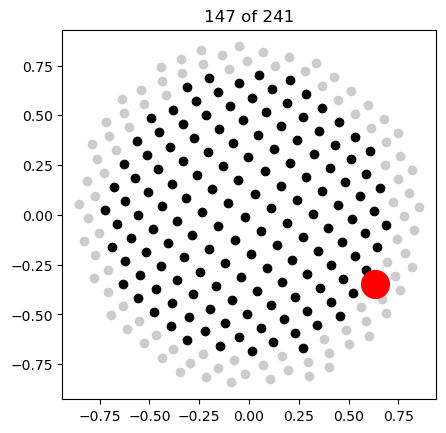

0.7629941848882963 -0.504432076728682
<SkyCoord (AltAz: obstime=2023-03-08 01:29:08.821672, location=(1845655.49905341, -5270856.2947176, -3075330.77760682) m, pressure=0.0 hPa, temperature=0.0 deg_C, relative_humidity=0.0, obswl=1.0 micron): (az, alt) in deg
    (331.09817095, 43.71634659)>
<SkyCoord (ICRS): (ra, dec) in deg
    (95.78777723, 12.62230747)>
ra_h:dec_d 6.38584994496532:12.6223023495922
/data/lvm/spec/agcam/east/20230308/lvm.spec.agcam.east_00000184.fits
---------------------------------


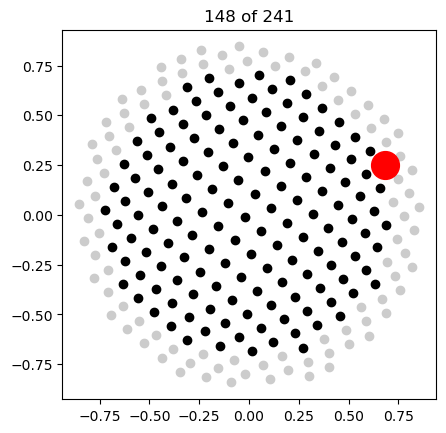

0.7585059714348648 0.3535310359632155
<SkyCoord (AltAz: obstime=2023-03-08 01:29:25.834017, location=(1845655.49905341, -5270856.2947176, -3075330.77760682) m, pressure=0.0 hPa, temperature=0.0 deg_C, relative_humidity=0.0, obswl=1.0 micron): (az, alt) in deg
    (20.25583629, 43.4591909)>
<SkyCoord (ICRS): (ra, dec) in deg
    (131.92731904, 15.27847498)>
ra_h:dec_d 8.79515728169714:15.2783808600088
/data/lvm/spec/agcam/east/20230308/lvm.spec.agcam.east_00000185.fits
---------------------------------


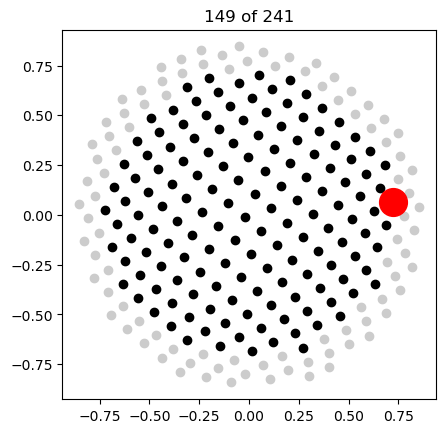

0.7567930269354234 0.09048058492882798
<SkyCoord (AltAz: obstime=2023-03-08 01:29:34.313295, location=(1845655.49905341, -5270856.2947176, -3075330.77760682) m, pressure=0.0 hPa, temperature=0.0 deg_C, relative_humidity=0.0, obswl=1.0 micron): (az, alt) in deg
    (5.18415564, 43.36104641)>
<SkyCoord (ICRS): (ra, dec) in deg
    (120.80985531, 17.5443846)>
ra_h:dec_d 8.05399373140508:17.5443681697894
/data/lvm/spec/agcam/east/20230308/lvm.spec.agcam.east_00000186.fits
---------------------------------


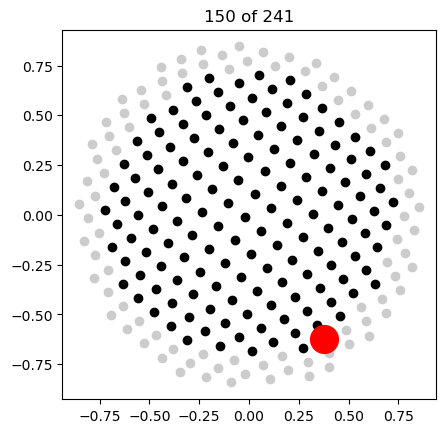

0.7542550328796063 -1.0240049814416579
<SkyCoord (AltAz: obstime=2023-03-08 01:29:48.029082, location=(1845655.49905341, -5270856.2947176, -3075330.77760682) m, pressure=0.0 hPa, temperature=0.0 deg_C, relative_humidity=0.0, obswl=1.0 micron): (az, alt) in deg
    (301.32883636, 43.21563006)>
<SkyCoord (ICRS): (ra, dec) in deg
    (78.45596507, -0.05940261)>
ra_h:dec_d 5.23040031501053:-0.0594913797330678
/data/lvm/spec/agcam/east/20230308/lvm.spec.agcam.east_00000187.fits
---------------------------------


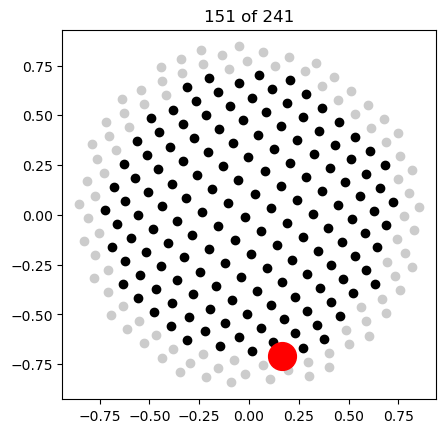

0.7535710224141974 -1.34120825822408
<SkyCoord (AltAz: obstime=2023-03-08 01:30:03.522881, location=(1845655.49905341, -5270856.2947176, -3075330.77760682) m, pressure=0.0 hPa, temperature=0.0 deg_C, relative_humidity=0.0, obswl=1.0 micron): (az, alt) in deg
    (283.15442736, 43.17643915)>
<SkyCoord (ICRS): (ra, dec) in deg
    (70.75768305, -10.79616215)>
ra_h:dec_d 4.71717829172358:-10.796067410451
/data/lvm/spec/agcam/east/20230308/lvm.spec.agcam.east_00000188.fits
---------------------------------


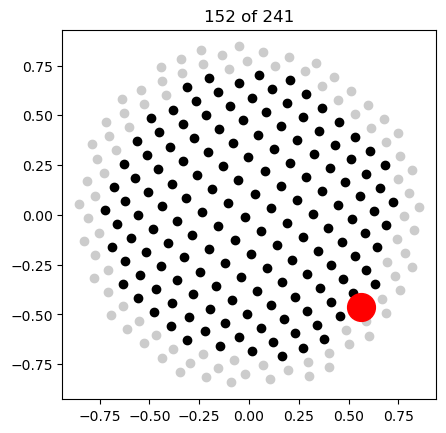

0.7519081782740121 -0.6884151166505362
<SkyCoord (AltAz: obstime=2023-03-08 01:30:17.018399, location=(1845655.49905341, -5270856.2947176, -3075330.77760682) m, pressure=0.0 hPa, temperature=0.0 deg_C, relative_humidity=0.0, obswl=1.0 micron): (az, alt) in deg
    (320.55671926, 43.0811652)>
<SkyCoord (ICRS): (ra, dec) in deg
    (89.00530604, 9.32803301)>
ra_h:dec_d 5.93369165422544:9.32798636094772
/data/lvm/spec/agcam/east/20230308/lvm.spec.agcam.east_00000189.fits
---------------------------------


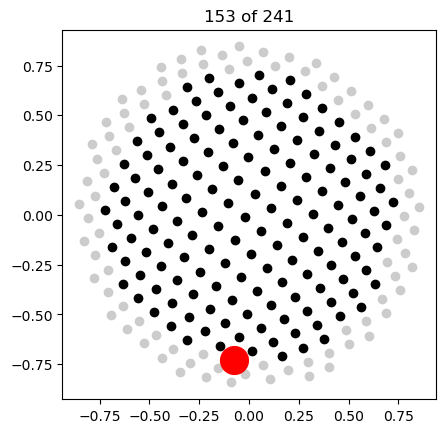

0.7512209714927389 -1.6762154676763292
<SkyCoord (AltAz: obstime=2023-03-08 01:30:31.350210, location=(1845655.49905341, -5270856.2947176, -3075330.77760682) m, pressure=0.0 hPa, temperature=0.0 deg_C, relative_humidity=0.0, obswl=1.0 micron): (az, alt) in deg
    (263.95992815, 43.04179115)>
<SkyCoord (ICRS): (ra, dec) in deg
    (64.78581837, -23.51726424)>
ra_h:dec_d 4.31905649874072:-23.5171576871116
/data/lvm/spec/agcam/east/20230308/lvm.spec.agcam.east_00000190.fits
---------------------------------


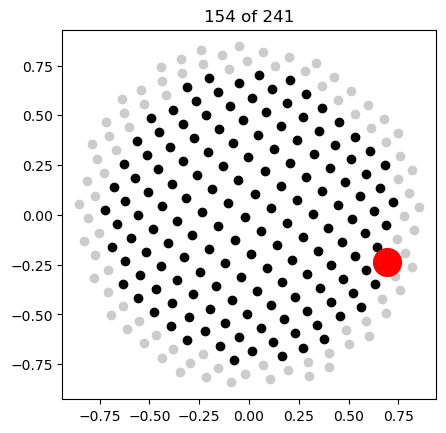

0.7511908212702341 -0.3267967247703787
<SkyCoord (AltAz: obstime=2023-03-08 01:30:46.381381, location=(1845655.49905341, -5270856.2947176, -3075330.77760682) m, pressure=0.0 hPa, temperature=0.0 deg_C, relative_humidity=0.0, obswl=1.0 micron): (az, alt) in deg
    (341.27592691, 43.04006367)>
<SkyCoord (ICRS): (ra, dec) in deg
    (103.04017176, 15.95823351)>
ra_h:dec_d 6.8693483289985:15.9582341118099
/data/lvm/spec/agcam/east/20230308/lvm.spec.agcam.east_00000191.fits
---------------------------------


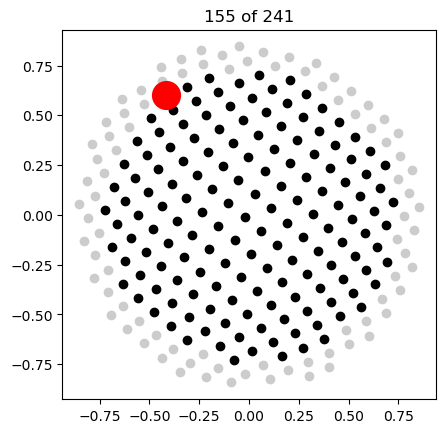

0.7511046407218754 2.1796655630430712
<SkyCoord (AltAz: obstime=2023-03-08 01:30:55.503265, location=(1845655.49905341, -5270856.2947176, -3075330.77760682) m, pressure=0.0 hPa, temperature=0.0 deg_C, relative_humidity=0.0, obswl=1.0 micron): (az, alt) in deg
    (124.88563751, 43.03512589)>
<SkyCoord (ICRS): (ra, dec) in deg
    (173.92545002, -44.02004285)>
ra_h:dec_d 11.5950390297038:-44.0200704732362
/data/lvm/spec/agcam/east/20230308/lvm.spec.agcam.east_00000192.fits
---------------------------------


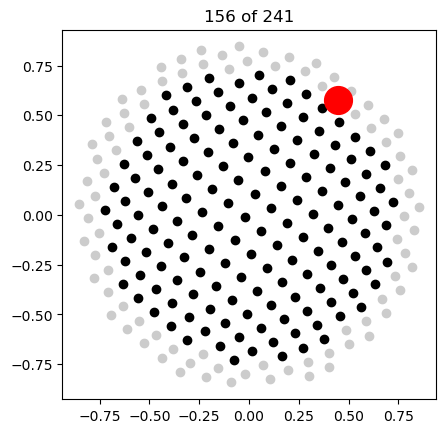

0.7485642938432887 0.9106333974552873
<SkyCoord (AltAz: obstime=2023-03-08 01:31:12.016238, location=(1845655.49905341, -5270856.2947176, -3075330.77760682) m, pressure=0.0 hPa, temperature=0.0 deg_C, relative_humidity=0.0, obswl=1.0 micron): (az, alt) in deg
    (52.17545036, 42.88957473)>
<SkyCoord (ICRS): (ra, dec) in deg
    (152.74071011, 3.72531352)>
ra_h:dec_d 10.1827157921758:3.7251676917258
/data/lvm/spec/agcam/east/20230308/lvm.spec.agcam.east_00000193.fits
---------------------------------


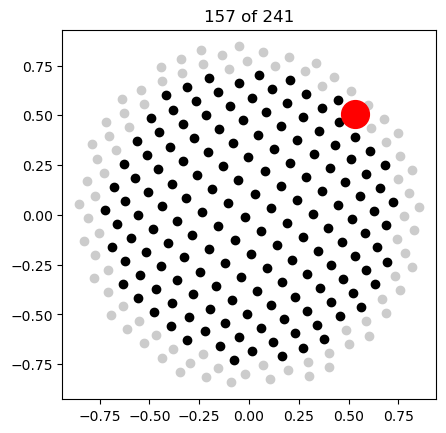

0.7440686061908892 0.761816804854569
<SkyCoord (AltAz: obstime=2023-03-08 01:31:27.606615, location=(1845655.49905341, -5270856.2947176, -3075330.77760682) m, pressure=0.0 hPa, temperature=0.0 deg_C, relative_humidity=0.0, obswl=1.0 micron): (az, alt) in deg
    (43.64888768, 42.6319908)>
<SkyCoord (ICRS): (ra, dec) in deg
    (148.19991758, 7.99585795)>
ra_h:dec_d 9.88000206273462:7.99570592478501
/data/lvm/spec/agcam/east/20230308/lvm.spec.agcam.east_00000194.fits
---------------------------------


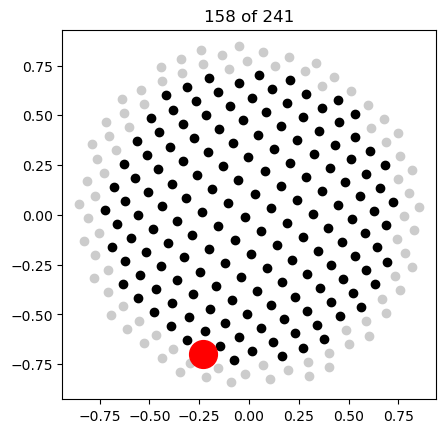

0.7426215763385791 -1.889121993320371
<SkyCoord (AltAz: obstime=2023-03-08 01:31:40.302993, location=(1845655.49905341, -5270856.2947176, -3075330.77760682) m, pressure=0.0 hPa, temperature=0.0 deg_C, relative_humidity=0.0, obswl=1.0 micron): (az, alt) in deg
    (251.7612828, 42.5490821)>
<SkyCoord (ICRS): (ra, dec) in deg
    (61.92735417, -32.03076383)>
ra_h:dec_d 4.12849304956633:-32.0308823294639
/data/lvm/spec/agcam/east/20230308/lvm.spec.agcam.east_00000195.fits
---------------------------------


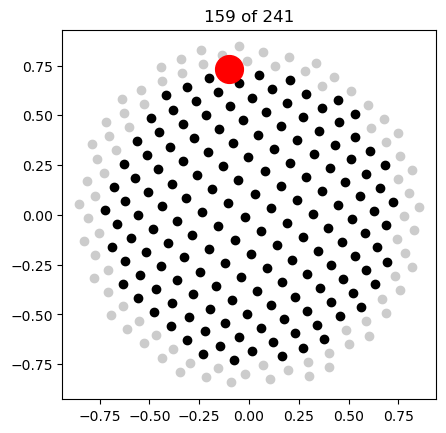

0.7408446529658023 1.7079451829076413
<SkyCoord (AltAz: obstime=2023-03-08 01:31:57.632051, location=(1845655.49905341, -5270856.2947176, -3075330.77760682) m, pressure=0.0 hPa, temperature=0.0 deg_C, relative_humidity=0.0, obswl=1.0 micron): (az, alt) in deg
    (97.85805062, 42.44727189)>
<SkyCoord (ICRS): (ra, dec) in deg
    (170.97884704, -24.42107702)>
ra_h:dec_d 11.3985917858428:-24.4211120699403
/data/lvm/spec/agcam/east/20230308/lvm.spec.agcam.east_00000196.fits
---------------------------------


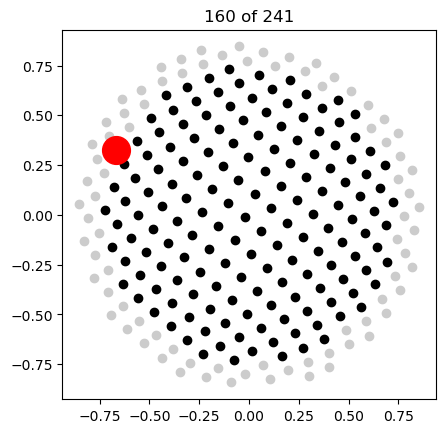

0.731912276437534 2.687390746979612
<SkyCoord (AltAz: obstime=2023-03-08 01:32:15.315138, location=(1845655.49905341, -5270856.2947176, -3075330.77760682) m, pressure=0.0 hPa, temperature=0.0 deg_C, relative_humidity=0.0, obswl=1.0 micron): (az, alt) in deg
    (153.9761477, 41.93548441)>
<SkyCoord (ICRS): (ra, dec) in deg
    (169.03567202, -65.19657963)>
ra_h:dec_d 11.2690495469282:-65.1966076505251
/data/lvm/spec/agcam/east/20230308/lvm.spec.agcam.east_00000197.fits
---------------------------------


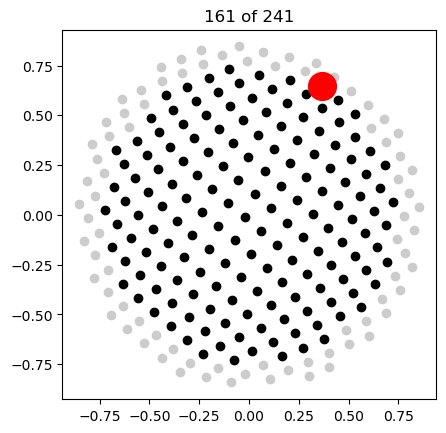

0.7300069854631611 1.058854085704558
<SkyCoord (AltAz: obstime=2023-03-08 01:32:30.201842, location=(1845655.49905341, -5270856.2947176, -3075330.77760682) m, pressure=0.0 hPa, temperature=0.0 deg_C, relative_humidity=0.0, obswl=1.0 micron): (az, alt) in deg
    (60.66787023, 41.82631928)>
<SkyCoord (ICRS): (ra, dec) in deg
    (158.14381382, -0.11355545)>
ra_h:dec_d 10.5429273393534:-0.113676244661733
/data/lvm/spec/agcam/east/20230308/lvm.spec.agcam.east_00000198.fits
---------------------------------


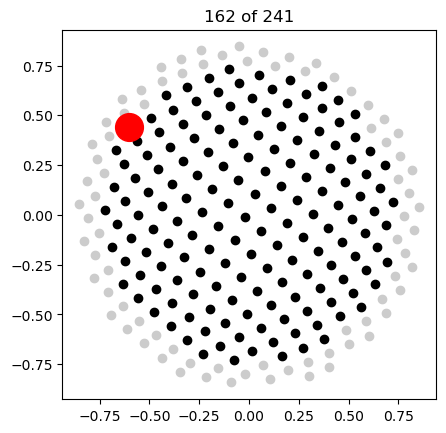

0.7289673064996842 2.508829889482794
<SkyCoord (AltAz: obstime=2023-03-08 01:32:46.485430, location=(1845655.49905341, -5270856.2947176, -3075330.77760682) m, pressure=0.0 hPa, temperature=0.0 deg_C, relative_humidity=0.0, obswl=1.0 micron): (az, alt) in deg
    (143.74536418, 41.76675007)>
<SkyCoord (ICRS): (ra, dec) in deg
    (174.30686517, -57.97530355)>
ra_h:dec_d 11.620457529771:-57.9753686653265
/data/lvm/spec/agcam/east/20230308/lvm.spec.agcam.east_00000199.fits
---------------------------------


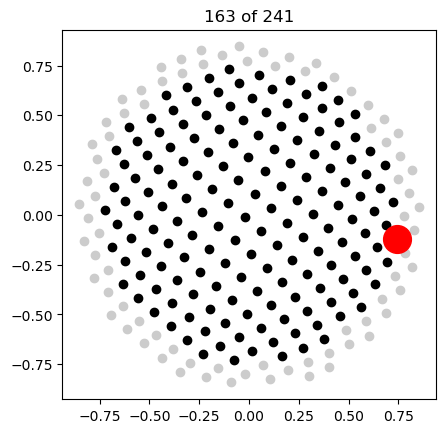

0.7208622860208128 -0.16031130195388135
<SkyCoord (AltAz: obstime=2023-03-08 01:33:02.434729, location=(1845655.49905341, -5270856.2947176, -3075330.77760682) m, pressure=0.0 hPa, temperature=0.0 deg_C, relative_humidity=0.0, obswl=1.0 micron): (az, alt) in deg
    (350.81483899, 41.3023666)>
<SkyCoord (ICRS): (ra, dec) in deg
    (110.42950164, 19.22615457)>
ra_h:dec_d 7.36196377384028:19.2260536435851
/data/lvm/spec/agcam/east/20230308/lvm.spec.agcam.east_00000200.fits
---------------------------------


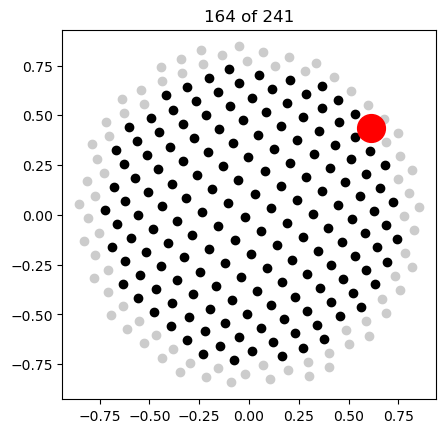

0.7193359974289302 0.6197282169859514
<SkyCoord (AltAz: obstime=2023-03-08 01:33:19.714241, location=(1845655.49905341, -5270856.2947176, -3075330.77760682) m, pressure=0.0 hPa, temperature=0.0 deg_C, relative_humidity=0.0, obswl=1.0 micron): (az, alt) in deg
    (35.50781128, 41.2149167)>
<SkyCoord (ICRS): (ra, dec) in deg
    (144.40182635, 12.58441441)>
ra_h:dec_d 9.62679404353901:12.5842436938624
/data/lvm/spec/agcam/east/20230308/lvm.spec.agcam.east_00000201.fits
---------------------------------


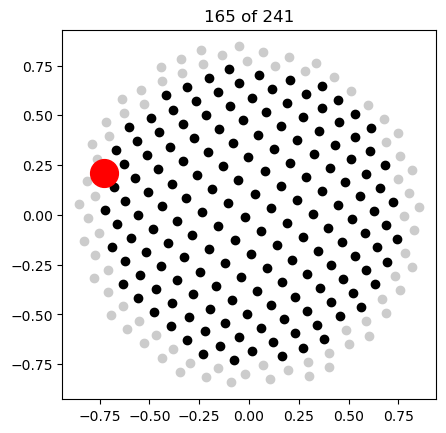

0.7139094582229182 2.857725971632081
<SkyCoord (AltAz: obstime=2023-03-08 01:33:34.926313, location=(1845655.49905341, -5270856.2947176, -3075330.77760682) m, pressure=0.0 hPa, temperature=0.0 deg_C, relative_humidity=0.0, obswl=1.0 micron): (az, alt) in deg
    (163.73563718, 40.90399891)>
<SkyCoord (ICRS): (ra, dec) in deg
    (161.79836414, -72.06362992)>
ra_h:dec_d 10.7865673524846:-72.0637190075789
/data/lvm/spec/agcam/east/20230308/lvm.spec.agcam.east_00000202.fits
---------------------------------


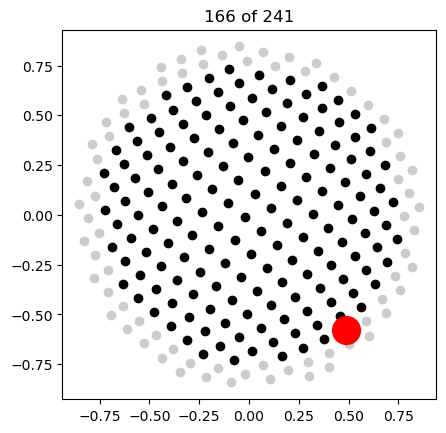

0.7135506610204787 -0.8717711526069408
<SkyCoord (AltAz: obstime=2023-03-08 01:33:52.204014, location=(1845655.49905341, -5270856.2947176, -3075330.77760682) m, pressure=0.0 hPa, temperature=0.0 deg_C, relative_humidity=0.0, obswl=1.0 micron): (az, alt) in deg
    (310.05119225, 40.88344135)>
<SkyCoord (ICRS): (ra, dec) in deg
    (82.3613015, 6.19037646)>
ra_h:dec_d 5.49075277753524:6.19039673168372
/data/lvm/spec/agcam/east/20230308/lvm.spec.agcam.east_00000203.fits
---------------------------------


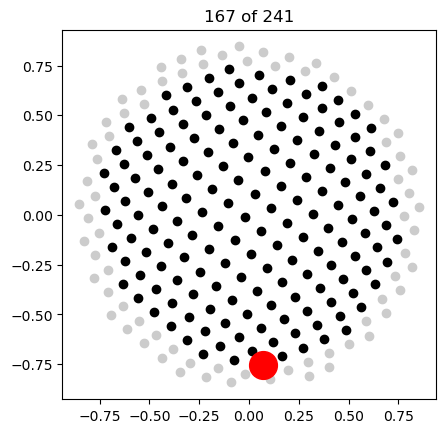

0.712085212922978 -1.4804017118087418
<SkyCoord (AltAz: obstime=2023-03-08 01:34:09.106386, location=(1845655.49905341, -5270856.2947176, -3075330.77760682) m, pressure=0.0 hPa, temperature=0.0 deg_C, relative_humidity=0.0, obswl=1.0 micron): (az, alt) in deg
    (275.17922993, 40.79947735)>
<SkyCoord (ICRS): (ra, dec) in deg
    (66.80768739, -14.94360306)>
ra_h:dec_d 4.45384801959372:-14.9435799808542
/data/lvm/spec/agcam/east/20230308/lvm.spec.agcam.east_00000204.fits
---------------------------------


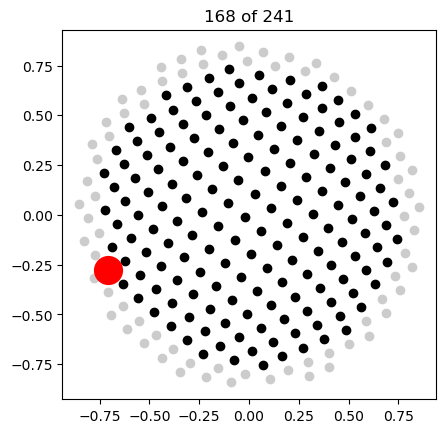

0.711342924068017 -2.7711317975378056
<SkyCoord (AltAz: obstime=2023-03-08 01:34:23.387576, location=(1845655.49905341, -5270856.2947176, -3075330.77760682) m, pressure=0.0 hPa, temperature=0.0 deg_C, relative_humidity=0.0, obswl=1.0 micron): (az, alt) in deg
    (201.22584353, 40.75694734)>
<SkyCoord (ICRS): (ra, dec) in deg
    (68.23404697, -69.12526602)>
ra_h:dec_d 4.54894883309419:-69.1252235041526
/data/lvm/spec/agcam/east/20230308/lvm.spec.agcam.east_00000205.fits
---------------------------------


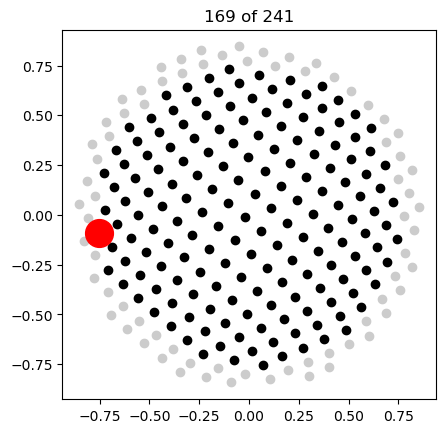

0.7112529839569238 -3.0243223560338484
<SkyCoord (AltAz: obstime=2023-03-08 01:34:38.910591, location=(1845655.49905341, -5270856.2947176, -3075330.77760682) m, pressure=0.0 hPa, temperature=0.0 deg_C, relative_humidity=0.0, obswl=1.0 micron): (az, alt) in deg
    (186.71909311, 40.75179415)>
<SkyCoord (ICRS): (ra, dec) in deg
    (95.45137615, -77.0181083)>
ra_h:dec_d 6.36341350696313:-77.018127128561
/data/lvm/spec/agcam/east/20230308/lvm.spec.agcam.east_00000206.fits
---------------------------------


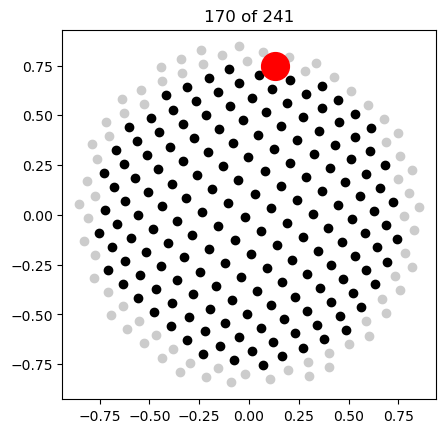

0.7083961453946037 1.3946370745479937
<SkyCoord (AltAz: obstime=2023-03-08 01:34:45.730494, location=(1845655.49905341, -5270856.2947176, -3075330.77760682) m, pressure=0.0 hPa, temperature=0.0 deg_C, relative_humidity=0.0, obswl=1.0 micron): (az, alt) in deg
    (79.90681832, 40.58810935)>
<SkyCoord (ICRS): (ra, dec) in deg
    (167.92355852, -11.35524299)>
ra_h:dec_d 11.1949078894426:-11.3553101642012
/data/lvm/spec/agcam/east/20230308/lvm.spec.agcam.east_00000207.fits
---------------------------------


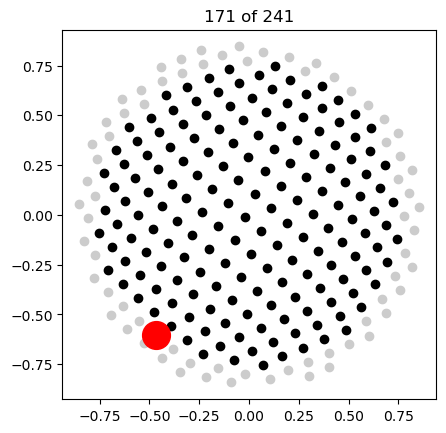

0.702992818059447 -2.2329848934864422
<SkyCoord (AltAz: obstime=2023-03-08 01:35:01.631548, location=(1845655.49905341, -5270856.2947176, -3075330.77760682) m, pressure=0.0 hPa, temperature=0.0 deg_C, relative_humidity=0.0, obswl=1.0 micron): (az, alt) in deg
    (232.05938989, 40.2785215)>
<SkyCoord (ICRS): (ra, dec) in deg
    (57.70740378, -46.42641557)>
ra_h:dec_d 11.194909615038:-11.355303870096
/data/lvm/spec/agcam/east/20230308/lvm.spec.agcam.east_00000208.fits
---------------------------------


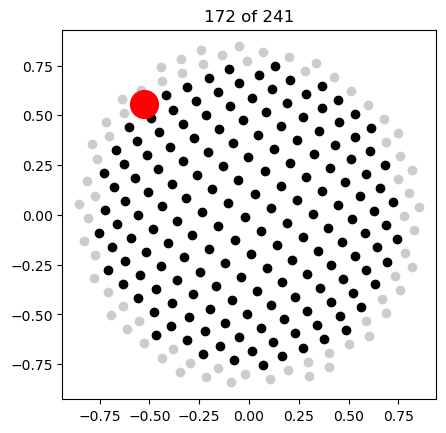

0.7005710701688704 2.327622254196468
<SkyCoord (AltAz: obstime=2023-03-08 01:35:09.233941, location=(1845655.49905341, -5270856.2947176, -3075330.77760682) m, pressure=0.0 hPa, temperature=0.0 deg_C, relative_humidity=0.0, obswl=1.0 micron): (az, alt) in deg
    (133.36293147, 40.13976557)>
<SkyCoord (ICRS): (ra, dec) in deg
    (179.19844327, -50.37320002)>
ra_h:dec_d 11.9465731132362:-50.3733348366511
/data/lvm/spec/agcam/east/20230308/lvm.spec.agcam.east_00000209.fits
---------------------------------


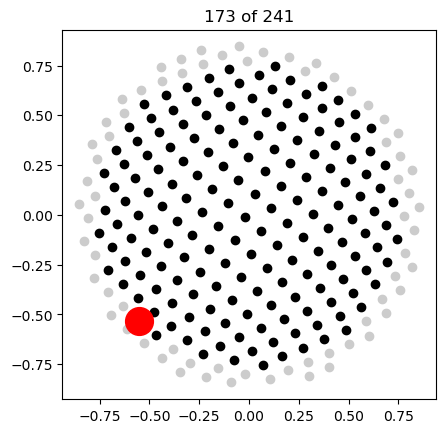

0.6978170388225379 -2.3763989819737663
<SkyCoord (AltAz: obstime=2023-03-08 01:35:26.533952, location=(1845655.49905341, -5270856.2947176, -3075330.77760682) m, pressure=0.0 hPa, temperature=0.0 deg_C, relative_humidity=0.0, obswl=1.0 micron): (az, alt) in deg
    (223.84236789, 39.9819712)>
<SkyCoord (ICRS): (ra, dec) in deg
    (57.49746532, -52.71007261)>
ra_h:dec_d 3.83316621565802:-52.7101959344599
/data/lvm/spec/agcam/east/20230308/lvm.spec.agcam.east_00000210.fits
---------------------------------


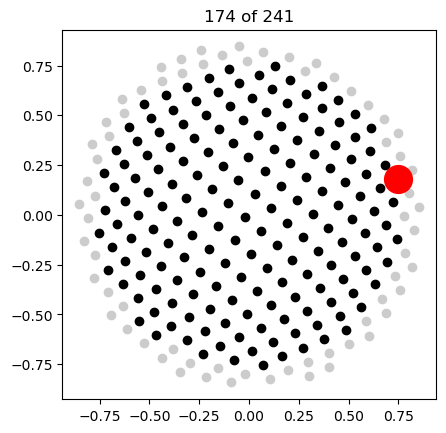

0.6937986197170892 0.2368478594893555
<SkyCoord (AltAz: obstime=2023-03-08 01:35:43.623878, location=(1845655.49905341, -5270856.2947176, -3075330.77760682) m, pressure=0.0 hPa, temperature=0.0 deg_C, relative_humidity=0.0, obswl=1.0 micron): (az, alt) in deg
    (13.57038274, 39.75173274)>
<SkyCoord (ICRS): (ra, dec) in deg
    (129.47609366, 20.17643529)>
ra_h:dec_d 8.63174204631185:20.1763547467232
/data/lvm/spec/agcam/east/20230308/lvm.spec.agcam.east_00000211.fits
---------------------------------


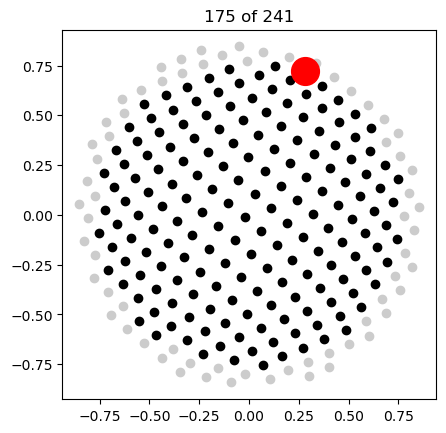

0.6862766336096165 1.1982445643664443
<SkyCoord (AltAz: obstime=2023-03-08 01:36:00.803494, location=(1845655.49905341, -5270856.2947176, -3075330.77760682) m, pressure=0.0 hPa, temperature=0.0 deg_C, relative_humidity=0.0, obswl=1.0 micron): (az, alt) in deg
    (68.65435636, 39.32075468)>
<SkyCoord (ICRS): (ra, dec) in deg
    (164.72147921, -3.36978945)>
ra_h:dec_d 10.9814375382542:-3.36986124794514
/data/lvm/spec/agcam/east/20230308/lvm.spec.agcam.east_00000212.fits
---------------------------------


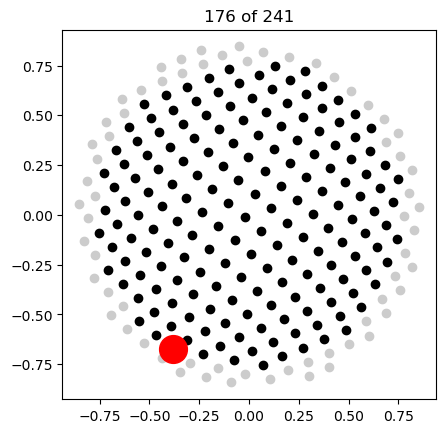

0.6851829654981583 -2.0891816052857988
<SkyCoord (AltAz: obstime=2023-03-08 01:36:15.505631, location=(1845655.49905341, -5270856.2947176, -3075330.77760682) m, pressure=0.0 hPa, temperature=0.0 deg_C, relative_humidity=0.0, obswl=1.0 micron): (az, alt) in deg
    (240.29871138, 39.25809212)>
<SkyCoord (ICRS): (ra, dec) in deg
    (57.31580498, -40.03408046)>
ra_h:dec_d 3.82106174507204:-40.0341170182311
/data/lvm/spec/agcam/east/20230308/lvm.spec.agcam.east_00000213.fits
---------------------------------


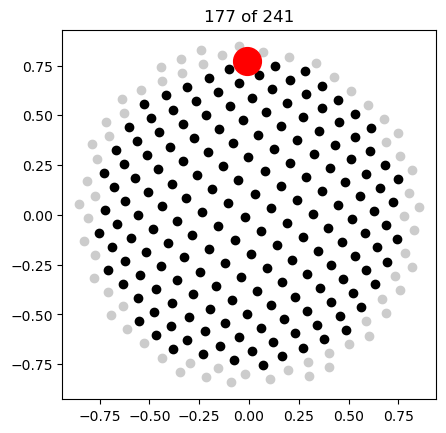

0.6843650169905103 1.5827381638290716
<SkyCoord (AltAz: obstime=2023-03-08 01:36:33.401661, location=(1845655.49905341, -5270856.2947176, -3075330.77760682) m, pressure=0.0 hPa, temperature=0.0 deg_C, relative_humidity=0.0, obswl=1.0 micron): (az, alt) in deg
    (90.68421686, 39.21122712)>
<SkyCoord (ICRS): (ra, dec) in deg
    (173.35791421, -18.20859447)>
ra_h:dec_d 11.5571962224746:-18.2085181344358
/data/lvm/spec/agcam/east/20230308/lvm.spec.agcam.east_00000214.fits
---------------------------------


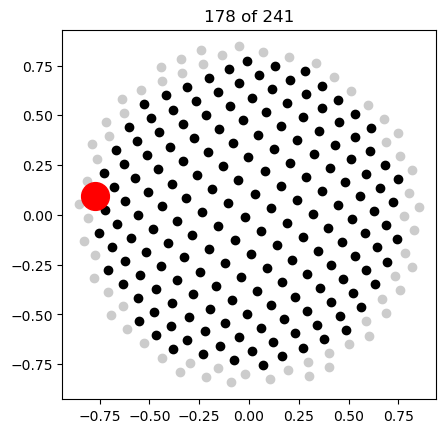

0.679260227933523 3.016625844464743
<SkyCoord (AltAz: obstime=2023-03-08 01:36:51.395221, location=(1845655.49905341, -5270856.2947176, -3075330.77760682) m, pressure=0.0 hPa, temperature=0.0 deg_C, relative_humidity=0.0, obswl=1.0 micron): (az, alt) in deg
    (172.83992926, 38.91874425)>
<SkyCoord (ICRS): (ra, dec) in deg
    (148.01350278, -78.34243406)>
ra_h:dec_d 9.86757141538081:-78.3424022380463
/data/lvm/spec/agcam/east/20230308/lvm.spec.agcam.east_00000215.fits
---------------------------------


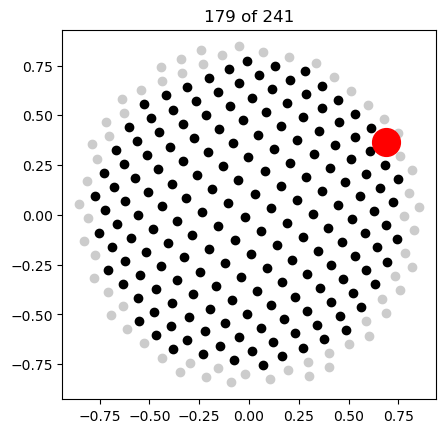

0.677744346822511 0.4891182837730629
<SkyCoord (AltAz: obstime=2023-03-08 01:37:06.990098, location=(1845655.49905341, -5270856.2947176, -3075330.77760682) m, pressure=0.0 hPa, temperature=0.0 deg_C, relative_humidity=0.0, obswl=1.0 micron): (az, alt) in deg
    (28.02441334, 38.83189066)>
<SkyCoord (ICRS): (ra, dec) in deg
    (141.30168824, 17.40107572)>
ra_h:dec_d 9.42011555792914:17.4009860067647
/data/lvm/spec/agcam/east/20230308/lvm.spec.agcam.east_00000216.fits
---------------------------------


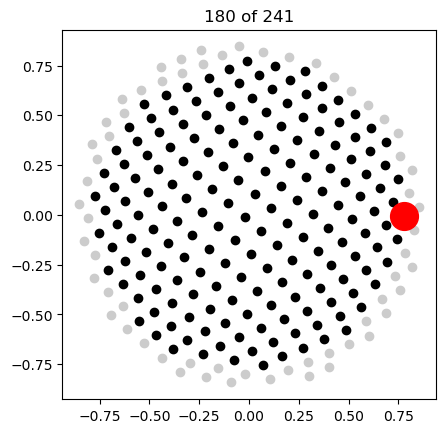

0.6761693026862389 -0.0066845710826208896
<SkyCoord (AltAz: obstime=2023-03-08 01:37:24.692537, location=(1845655.49905341, -5270856.2947176, -3075330.77760682) m, pressure=0.0 hPa, temperature=0.0 deg_C, relative_humidity=0.0, obswl=1.0 micron): (az, alt) in deg
    (359.61700229, 38.74164728)>
<SkyCoord (ICRS): (ra, dec) in deg
    (118.49163448, 22.31421842)>
ra_h:dec_d 9.42011151906363:17.4010870450634
/data/lvm/spec/agcam/east/20230308/lvm.spec.agcam.east_00000217.fits
---------------------------------


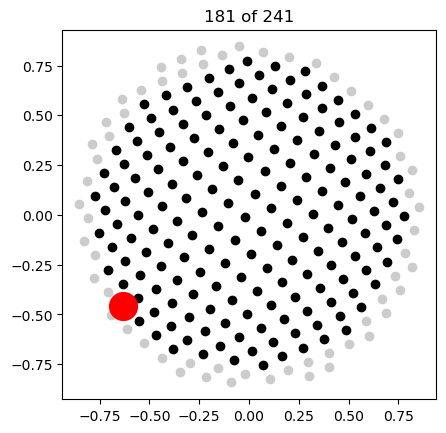

0.6727300475119607 -2.513063282193731
<SkyCoord (AltAz: obstime=2023-03-08 01:37:32.315018, location=(1845655.49905341, -5270856.2947176, -3075330.77760682) m, pressure=0.0 hPa, temperature=0.0 deg_C, relative_humidity=0.0, obswl=1.0 micron): (az, alt) in deg
    (216.01208028, 38.54459247)>
<SkyCoord (ICRS): (ra, dec) in deg
    (56.46119136, -58.87548446)>
ra_h:dec_d 3.76408420152383:-58.8753677786367
/data/lvm/spec/agcam/east/20230308/lvm.spec.agcam.east_00000218.fits
---------------------------------


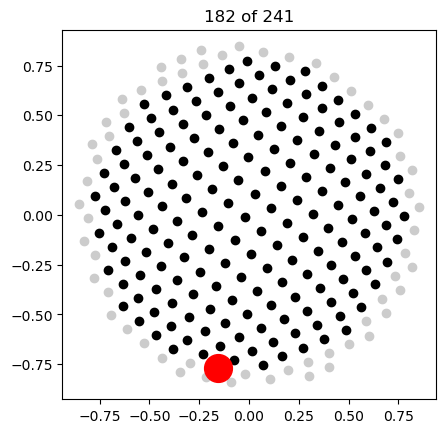

0.666383333350433 -1.7695060963594673
<SkyCoord (AltAz: obstime=2023-03-08 01:37:49.903735, location=(1845655.49905341, -5270856.2947176, -3075330.77760682) m, pressure=0.0 hPa, temperature=0.0 deg_C, relative_humidity=0.0, obswl=1.0 micron): (az, alt) in deg
    (258.61476886, 38.18095254)>
<SkyCoord (ICRS): (ra, dec) in deg
    (60.15426871, -25.87356624)>
ra_h:dec_d 4.01028313111062:-25.8735853928539
/data/lvm/spec/agcam/east/20230308/lvm.spec.agcam.east_00000219.fits
---------------------------------


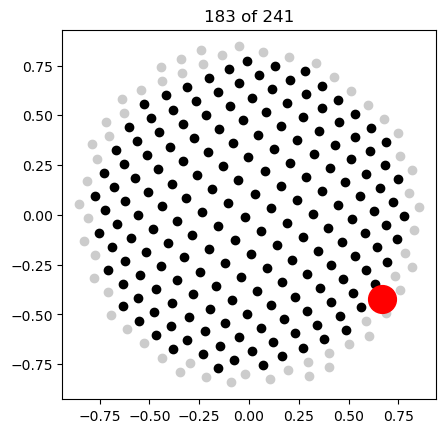

0.664149729893484 -0.562927799751065
<SkyCoord (AltAz: obstime=2023-03-08 01:38:04.438462, location=(1845655.49905341, -5270856.2947176, -3075330.77760682) m, pressure=0.0 hPa, temperature=0.0 deg_C, relative_humidity=0.0, obswl=1.0 micron): (az, alt) in deg
    (327.7466129, 38.05297649)>
<SkyCoord (ICRS): (ra, dec) in deg
    (93.00120204, 16.47837654)>
ra_h:dec_d 6.20008353637762:16.478331899355
/data/lvm/spec/agcam/east/20230308/lvm.spec.agcam.east_00000220.fits
---------------------------------


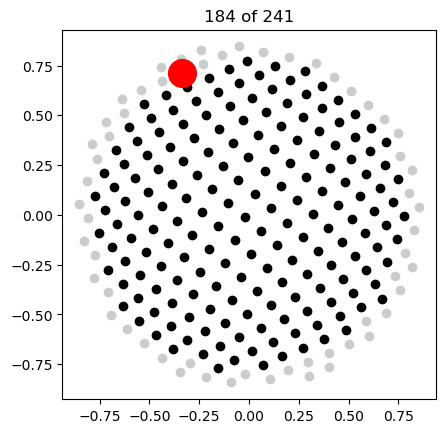

0.6619705212484234 2.0089072672300836
<SkyCoord (AltAz: obstime=2023-03-08 01:38:20.182982, location=(1845655.49905341, -5270856.2947176, -3075330.77760682) m, pressure=0.0 hPa, temperature=0.0 deg_C, relative_humidity=0.0, obswl=1.0 micron): (az, alt) in deg
    (115.10190785, 37.92811703)>
<SkyCoord (ICRS): (ra, dec) in deg
    (181.36856708, -36.0771314)>
ra_h:dec_d 12.0912454293102:-36.077258933754
/data/lvm/spec/agcam/east/20230308/lvm.spec.agcam.east_00000221.fits
---------------------------------


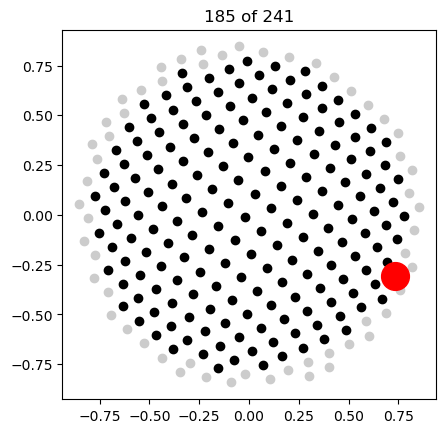

0.6564031768798462 -0.39593628814142023
<SkyCoord (AltAz: obstime=2023-03-08 01:38:37.401566, location=(1845655.49905341, -5270856.2947176, -3075330.77760682) m, pressure=0.0 hPa, temperature=0.0 deg_C, relative_humidity=0.0, obswl=1.0 micron): (az, alt) in deg
    (337.31452173, 37.60913169)>
<SkyCoord (ICRS): (ra, dec) in deg
    (100.13609314, 20.10216534)>
ra_h:dec_d 6.67574480526972:20.1022390756016
/data/lvm/spec/agcam/east/20230308/lvm.spec.agcam.east_00000222.fits
---------------------------------


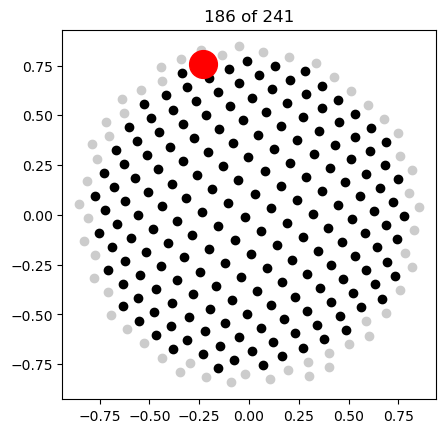

0.6551122385518346 1.868573478262699
<SkyCoord (AltAz: obstime=2023-03-08 01:38:54.238008, location=(1845655.49905341, -5270856.2947176, -3075330.77760682) m, pressure=0.0 hPa, temperature=0.0 deg_C, relative_humidity=0.0, obswl=1.0 micron): (az, alt) in deg
    (107.06137401, 37.53516638)>
<SkyCoord (ICRS): (ra, dec) in deg
    (180.24386731, -29.79672869)>
ra_h:dec_d 12.0162638765083:-29.7967976688322
/data/lvm/spec/agcam/east/20230308/lvm.spec.agcam.east_00000223.fits
---------------------------------


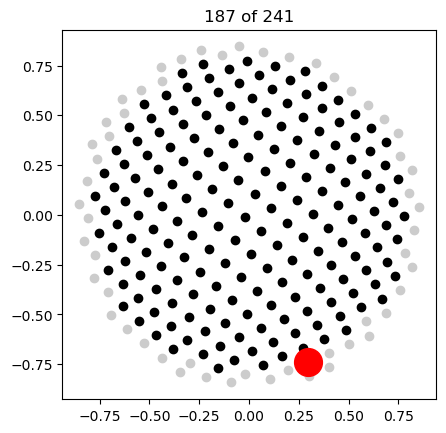

0.6524036878110622 -1.1883759534625344
<SkyCoord (AltAz: obstime=2023-03-08 01:39:11.120690, location=(1845655.49905341, -5270856.2947176, -3075330.77760682) m, pressure=0.0 hPa, temperature=0.0 deg_C, relative_humidity=0.0, obswl=1.0 micron): (az, alt) in deg
    (291.91107339, 37.37997785)>
<SkyCoord (ICRS): (ra, dec) in deg
    (71.7800159, -2.04604091)>
ra_h:dec_d 4.78534050158078:-2.0460196004149
/data/lvm/spec/agcam/east/20230308/lvm.spec.agcam.east_00000224.fits
---------------------------------


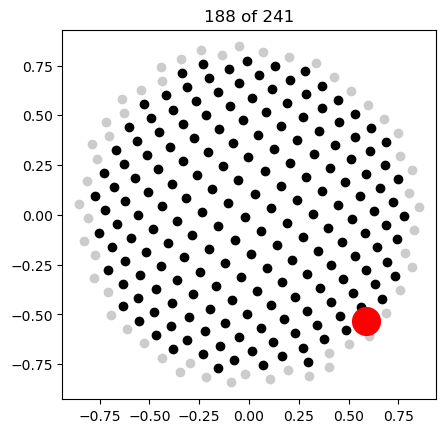

0.6495559828271819 -0.7365389374286484
<SkyCoord (AltAz: obstime=2023-03-08 01:39:29.311091, location=(1845655.49905341, -5270856.2947176, -3075330.77760682) m, pressure=0.0 hPa, temperature=0.0 deg_C, relative_humidity=0.0, obswl=1.0 micron): (az, alt) in deg
    (317.79942744, 37.21681637)>
<SkyCoord (ICRS): (ra, dec) in deg
    (86.07664978, 12.85777433)>
ra_h:dec_d 5.7384523742403:12.8578027891001
/data/lvm/spec/agcam/east/20230308/lvm.spec.agcam.east_00000225.fits
---------------------------------


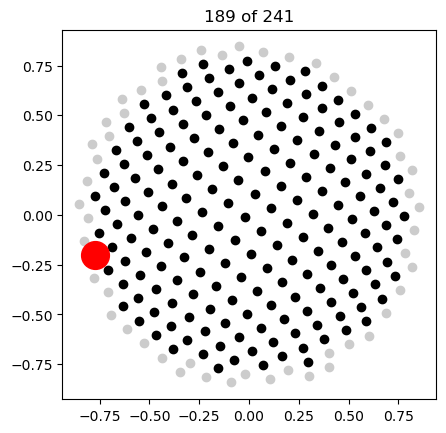

0.6473451732749128 -2.883840296722285
<SkyCoord (AltAz: obstime=2023-03-08 01:39:36.218037, location=(1845655.49905341, -5270856.2947176, -3075330.77760682) m, pressure=0.0 hPa, temperature=0.0 deg_C, relative_humidity=0.0, obswl=1.0 micron): (az, alt) in deg
    (194.76812221, 37.09014632)>
<SkyCoord (ICRS): (ra, dec) in deg
    (66.9018721, -75.28842159)>
ra_h:dec_d 4.46014275718914:-75.288341708077
/data/lvm/spec/agcam/east/20230308/lvm.spec.agcam.east_00000226.fits
---------------------------------


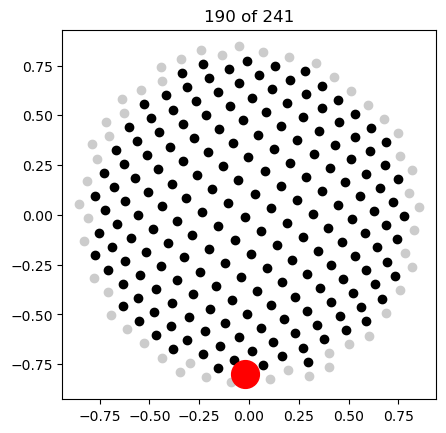

0.6469850406050922 -1.5931221399242363
<SkyCoord (AltAz: obstime=2023-03-08 01:39:53.603486, location=(1845655.49905341, -5270856.2947176, -3075330.77760682) m, pressure=0.0 hPa, temperature=0.0 deg_C, relative_humidity=0.0, obswl=1.0 micron): (az, alt) in deg
    (268.72082513, 37.06951223)>
<SkyCoord (ICRS): (ra, dec) in deg
    (62.55082039, -17.98629325)>
ra_h:dec_d 4.17005607661192:-17.9862493347088
/data/lvm/spec/agcam/east/20230308/lvm.spec.agcam.east_00000227.fits
---------------------------------


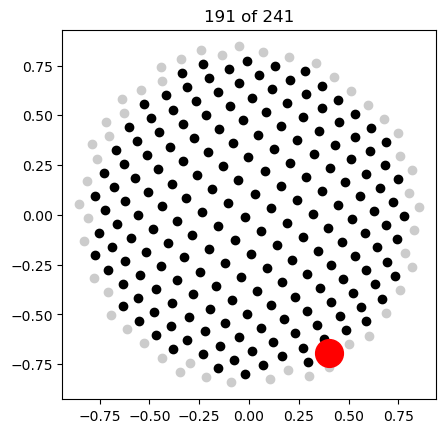

0.6428427030944813 -1.0478685263029608
<SkyCoord (AltAz: obstime=2023-03-08 01:40:09.186499, location=(1845655.49905341, -5270856.2947176, -3075330.77760682) m, pressure=0.0 hPa, temperature=0.0 deg_C, relative_humidity=0.0, obswl=1.0 micron): (az, alt) in deg
    (299.96155596, 36.83217378)>
<SkyCoord (ICRS): (ra, dec) in deg
    (75.54636959, 3.34728114)>
ra_h:dec_d 5.03642775138227:3.34737698670461
/data/lvm/spec/agcam/east/20230308/lvm.spec.agcam.east_00000228.fits
---------------------------------


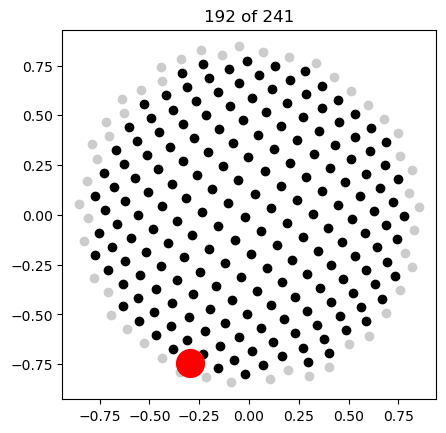

0.641677446556458 -1.9523542286890256
<SkyCoord (AltAz: obstime=2023-03-08 01:40:23.417249, location=(1845655.49905341, -5270856.2947176, -3075330.77760682) m, pressure=0.0 hPa, temperature=0.0 deg_C, relative_humidity=0.0, obswl=1.0 micron): (az, alt) in deg
    (248.13834258, 36.7654095)>
<SkyCoord (ICRS): (ra, dec) in deg
    (56.68487296, -33.50968835)>
ra_h:dec_d 3.77898901883645:-33.5095979413624
/data/lvm/spec/agcam/east/20230308/lvm.spec.agcam.east_00000229.fits
---------------------------------


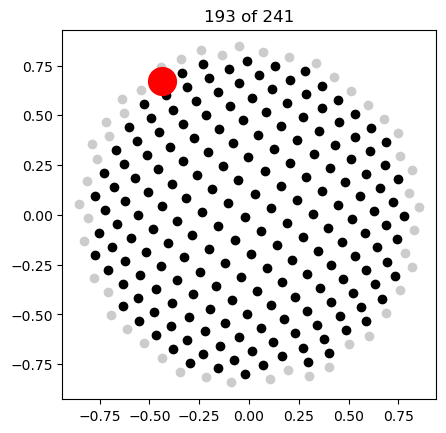

0.6416203826220864 2.1499364639904646
<SkyCoord (AltAz: obstime=2023-03-08 01:40:38.651015, location=(1845655.49905341, -5270856.2947176, -3075330.77760682) m, pressure=0.0 hPa, temperature=0.0 deg_C, relative_humidity=0.0, obswl=1.0 micron): (az, alt) in deg
    (123.18228561, 36.76213997)>
<SkyCoord (ICRS): (ra, dec) in deg
    (184.78746542, -42.22208044)>
ra_h:dec_d 12.3191691390313:-42.2221006667286
/data/lvm/spec/agcam/east/20230308/lvm.spec.agcam.east_00000230.fits
---------------------------------


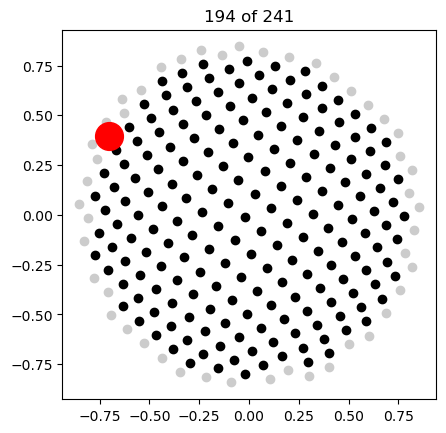

0.6348037566029593 2.625585374123257
<SkyCoord (AltAz: obstime=2023-03-08 01:40:56.704594, location=(1845655.49905341, -5270856.2947176, -3075330.77760682) m, pressure=0.0 hPa, temperature=0.0 deg_C, relative_humidity=0.0, obswl=1.0 micron): (az, alt) in deg
    (150.43496069, 36.37157607)>
<SkyCoord (ICRS): (ra, dec) in deg
    (185.45432814, -64.03799656)>
ra_h:dec_d 12.363628769254:-64.038019968602
/data/lvm/spec/agcam/east/20230308/lvm.spec.agcam.east_00000231.fits
---------------------------------


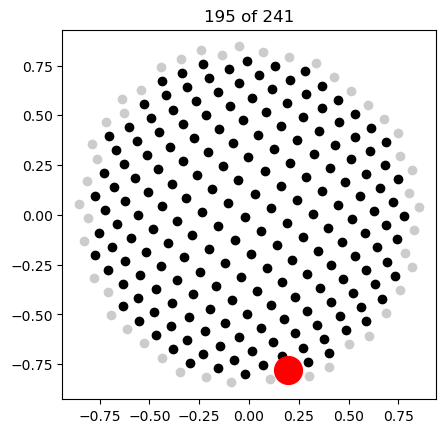

0.6343838638598395 -1.3239470389177366
<SkyCoord (AltAz: obstime=2023-03-08 01:41:10.596296, location=(1845655.49905341, -5270856.2947176, -3075330.77760682) m, pressure=0.0 hPa, temperature=0.0 deg_C, relative_humidity=0.0, obswl=1.0 micron): (az, alt) in deg
    (284.14342237, 36.34751799)>
<SkyCoord (ICRS): (ra, dec) in deg
    (67.98566634, -6.66435663)>
ra_h:dec_d 4.53238563385807:-6.66426520257665
/data/lvm/spec/agcam/east/20230308/lvm.spec.agcam.east_00000232.fits
---------------------------------


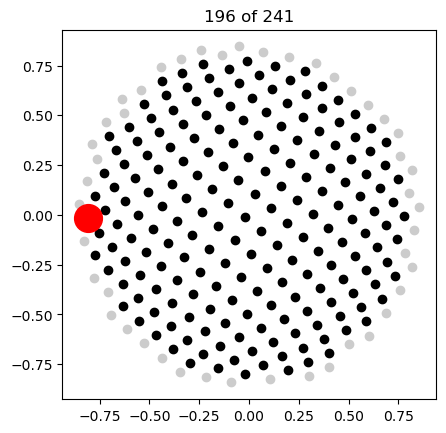

0.6318886360473968 -3.1196222349366978
<SkyCoord (AltAz: obstime=2023-03-08 01:41:28.032202, location=(1845655.49905341, -5270856.2947176, -3075330.77760682) m, pressure=0.0 hPa, temperature=0.0 deg_C, relative_humidity=0.0, obswl=1.0 micron): (az, alt) in deg
    (181.25881226, 36.20455197)>
<SkyCoord (ICRS): (ra, dec) in deg
    (112.7420576, -82.66998541)>
ra_h:dec_d 7.51613887806143:-82.6699159336472
/data/lvm/spec/agcam/east/20230308/lvm.spec.agcam.east_00000233.fits
---------------------------------


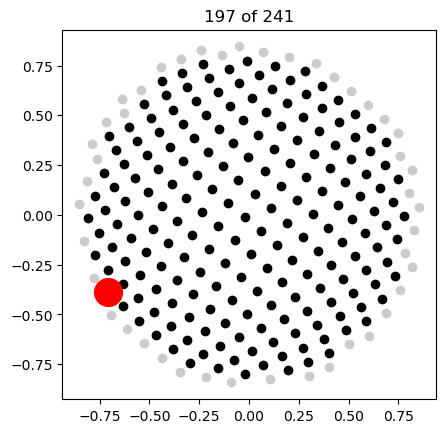

0.6311424763274605 -2.638936255370111
<SkyCoord (AltAz: obstime=2023-03-08 01:41:44.339844, location=(1845655.49905341, -5270856.2947176, -3075330.77760682) m, pressure=0.0 hPa, temperature=0.0 deg_C, relative_humidity=0.0, obswl=1.0 micron): (az, alt) in deg
    (208.80009016, 36.16180016)>
<SkyCoord (ICRS): (ra, dec) in deg
    (54.15576082, -64.87614827)>
ra_h:dec_d 3.61039182243644:-64.8761619718713
/data/lvm/spec/agcam/east/20230308/lvm.spec.agcam.east_00000234.fits
---------------------------------


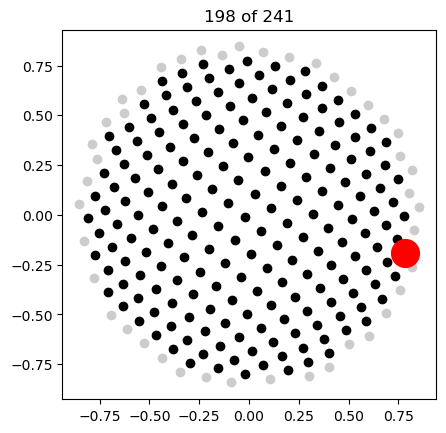

0.6308642138746868 -0.2385654888320747
<SkyCoord (AltAz: obstime=2023-03-08 01:41:59.034446, location=(1845655.49905341, -5270856.2947176, -3075330.77760682) m, pressure=0.0 hPa, temperature=0.0 deg_C, relative_humidity=0.0, obswl=1.0 micron): (az, alt) in deg
    (346.33120435, 36.1458569)>
<SkyCoord (ICRS): (ra, dec) in deg
    (107.93568241, 23.63212008)>
ra_h:dec_d 7.1957150831034:23.6320918838181
/data/lvm/spec/agcam/east/20230308/lvm.spec.agcam.east_00000235.fits
---------------------------------


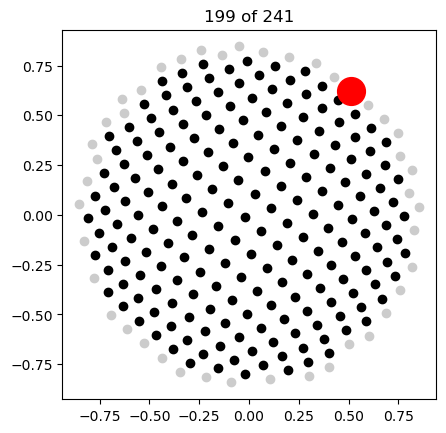

0.6307951710082556 0.8802070306669733
<SkyCoord (AltAz: obstime=2023-03-08 01:42:16.888148, location=(1845655.49905341, -5270856.2947176, -3075330.77760682) m, pressure=0.0 hPa, temperature=0.0 deg_C, relative_humidity=0.0, obswl=1.0 micron): (az, alt) in deg
    (50.43214795, 36.14190104)>
<SkyCoord (ICRS): (ra, dec) in deg
    (159.20084197, 9.55638121)>
ra_h:dec_d 10.6134011809771:9.55624361862342
/data/lvm/spec/agcam/east/20230308/lvm.spec.agcam.east_00000236.fits
---------------------------------


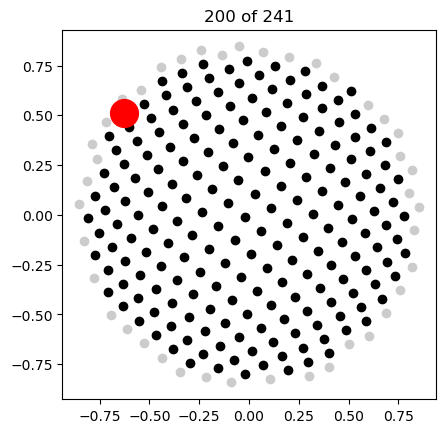

0.6283811492778746 2.456318512839004
<SkyCoord (AltAz: obstime=2023-03-08 01:42:33.191890, location=(1845655.49905341, -5270856.2947176, -3075330.77760682) m, pressure=0.0 hPa, temperature=0.0 deg_C, relative_humidity=0.0, obswl=1.0 micron): (az, alt) in deg
    (140.73668393, 36.00358778)>
<SkyCoord (ICRS): (ra, dec) in deg
    (187.77932668, -56.26280118)>
ra_h:dec_d 12.5186223716614:-56.2628081932924
/data/lvm/spec/agcam/east/20230308/lvm.spec.agcam.east_00000237.fits
---------------------------------


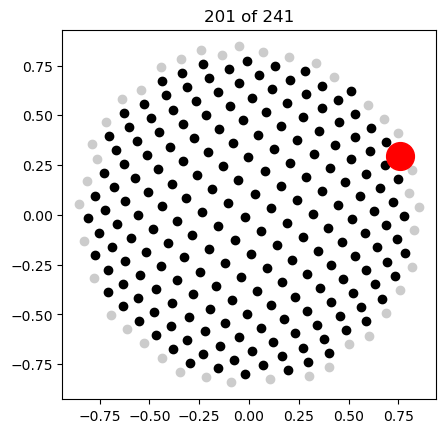

0.6227777835749947 0.3718134501960532
<SkyCoord (AltAz: obstime=2023-03-08 01:42:49.717500, location=(1845655.49905341, -5270856.2947176, -3075330.77760682) m, pressure=0.0 hPa, temperature=0.0 deg_C, relative_humidity=0.0, obswl=1.0 micron): (az, alt) in deg
    (21.30334146, 35.68253857)>
<SkyCoord (ICRS): (ra, dec) in deg
    (138.77856927, 22.37051143)>
ra_h:dec_d 9.25190769768171:22.3704107515649
/data/lvm/spec/agcam/east/20230308/lvm.spec.agcam.east_00000238.fits
---------------------------------


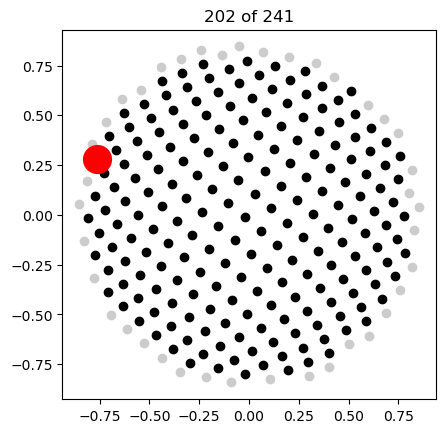

0.6207898997851641 2.786790187726421
<SkyCoord (AltAz: obstime=2023-03-08 01:43:07.206303, location=(1845655.49905341, -5270856.2947176, -3075330.77760682) m, pressure=0.0 hPa, temperature=0.0 deg_C, relative_humidity=0.0, obswl=1.0 micron): (az, alt) in deg
    (159.67131615, 35.56864122)>
<SkyCoord (ICRS): (ra, dec) in deg
    (184.08221614, -71.51974499)>
ra_h:dec_d 12.2721562494448:-71.5197843685343
/data/lvm/spec/agcam/east/20230308/lvm.spec.agcam.east_00000239.fits
---------------------------------


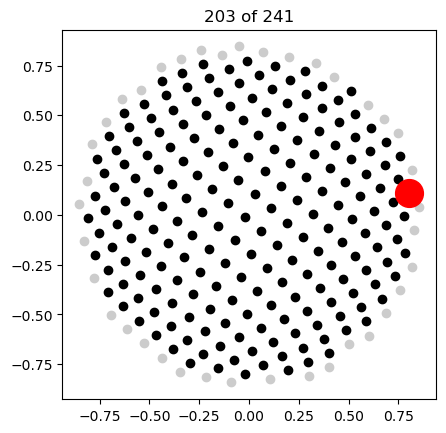

0.6207623576251982 0.13501060251341926
<SkyCoord (AltAz: obstime=2023-03-08 01:43:25.212256, location=(1845655.49905341, -5270856.2947176, -3075330.77760682) m, pressure=0.0 hPa, temperature=0.0 deg_C, relative_humidity=0.0, obswl=1.0 micron): (az, alt) in deg
    (7.73553771, 35.56706317)>
<SkyCoord (ICRS): (ra, dec) in deg
    (127.25815497, 25.09633993)>
ra_h:dec_d 8.48387787177107:25.0962598657844
/data/lvm/spec/agcam/east/20230308/lvm.spec.agcam.east_00000240.fits
---------------------------------


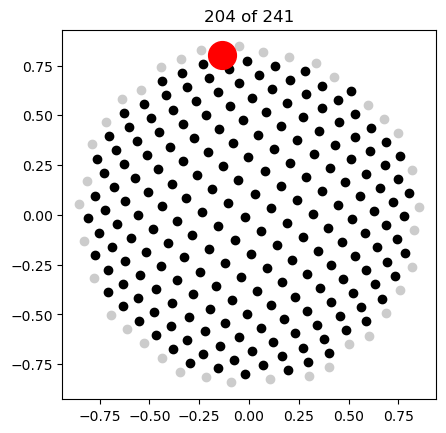

0.6207104806293262 1.7397920226734434
<SkyCoord (AltAz: obstime=2023-03-08 01:43:43.490798, location=(1845655.49905341, -5270856.2947176, -3075330.77760682) m, pressure=0.0 hPa, temperature=0.0 deg_C, relative_humidity=0.0, obswl=1.0 micron): (az, alt) in deg
    (99.68274013, 35.56409084)>
<SkyCoord (ICRS): (ra, dec) in deg
    (181.55895267, -23.55269084)>
ra_h:dec_d 12.1039449770195:-23.5528361950264
/data/lvm/spec/agcam/east/20230308/lvm.spec.agcam.east_00000241.fits
---------------------------------


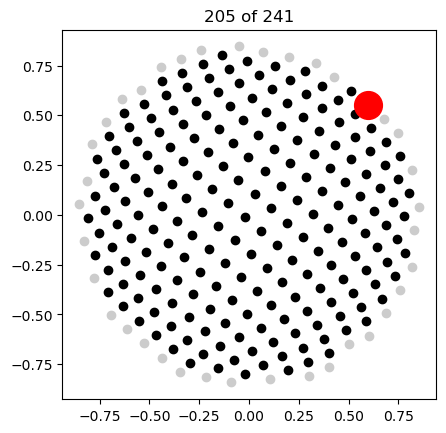

0.6201819471283058 0.744835014256428
<SkyCoord (AltAz: obstime=2023-03-08 01:43:59.704476, location=(1845655.49905341, -5270856.2947176, -3075330.77760682) m, pressure=0.0 hPa, temperature=0.0 deg_C, relative_humidity=0.0, obswl=1.0 micron): (az, alt) in deg
    (42.67590275, 35.5338081)>
<SkyCoord (ICRS): (ra, dec) in deg
    (155.13722905, 14.09023651)>
ra_h:dec_d 10.3424859521038:14.090073297691
/data/lvm/spec/agcam/east/20230308/lvm.spec.agcam.east_00000242.fits
---------------------------------


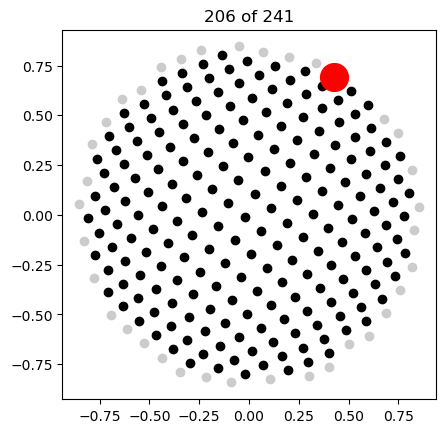

0.6190392473857581 1.0186945009714408
<SkyCoord (AltAz: obstime=2023-03-08 01:44:08.007246, location=(1845655.49905341, -5270856.2947176, -3075330.77760682) m, pressure=0.0 hPa, temperature=0.0 deg_C, relative_humidity=0.0, obswl=1.0 micron): (az, alt) in deg
    (58.36689552, 35.46833623)>
<SkyCoord (ICRS): (ra, dec) in deg
    (164.68012562, 5.41789213)>
ra_h:dec_d 10.9786853957754:5.41786895668851
/data/lvm/spec/agcam/east/20230308/lvm.spec.agcam.east_00000243.fits
---------------------------------


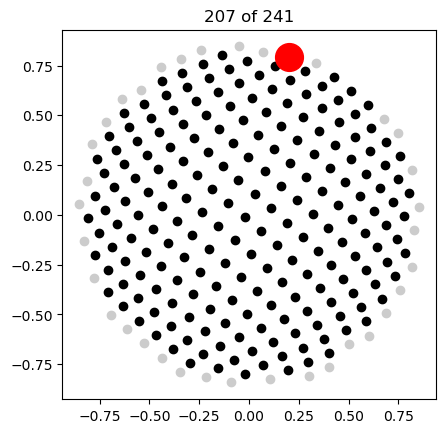

0.6152378033071418 1.3217903859561855
<SkyCoord (AltAz: obstime=2023-03-08 01:44:21.401608, location=(1845655.49905341, -5270856.2947176, -3075330.77760682) m, pressure=0.0 hPa, temperature=0.0 deg_C, relative_humidity=0.0, obswl=1.0 micron): (az, alt) in deg
    (75.73301052, 35.25052953)>
<SkyCoord (ICRS): (ra, dec) in deg
    (173.3284861, -5.83040658)>
ra_h:dec_d 11.5552450796201:-5.8304702803492
/data/lvm/spec/agcam/east/20230308/lvm.spec.agcam.east_00000244.fits
---------------------------------


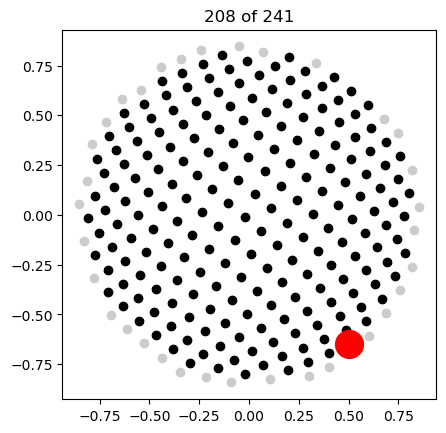

0.607275147886967 -0.9125634284186184
<SkyCoord (AltAz: obstime=2023-03-08 01:44:35.036181, location=(1845655.49905341, -5270856.2947176, -3075330.77760682) m, pressure=0.0 hPa, temperature=0.0 deg_C, relative_humidity=0.0, obswl=1.0 micron): (az, alt) in deg
    (307.71396701, 34.79430298)>
<SkyCoord (ICRS): (ra, dec) in deg
    (79.46339617, 9.33822109)>
ra_h:dec_d 5.29756529887101:9.33827319932654
/data/lvm/spec/agcam/east/20230308/lvm.spec.agcam.east_00000245.fits
---------------------------------


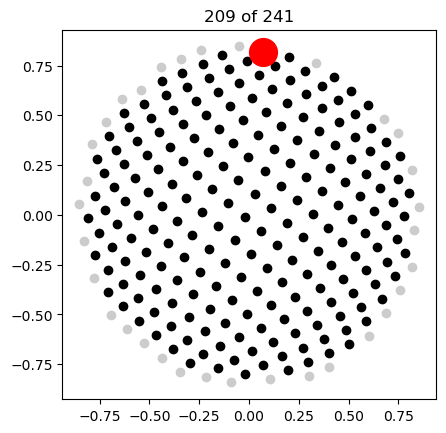

0.6069315170867638 1.4876013360656604
<SkyCoord (AltAz: obstime=2023-03-08 01:44:53.394869, location=(1845655.49905341, -5270856.2947176, -3075330.77760682) m, pressure=0.0 hPa, temperature=0.0 deg_C, relative_humidity=0.0, obswl=1.0 micron): (az, alt) in deg
    (85.23327815, 34.77461438)>
<SkyCoord (ICRS): (ra, dec) in deg
    (177.71911449, -12.39389578)>
ra_h:dec_d 11.8479448235993:-12.3938897183167
/data/lvm/spec/agcam/east/20230308/lvm.spec.agcam.east_00000246.fits
---------------------------------


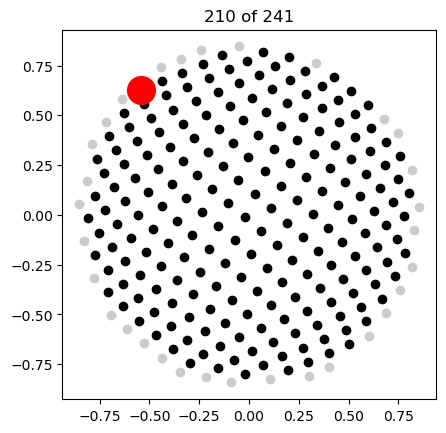

0.5963144409243277 2.2822459782036875
<SkyCoord (AltAz: obstime=2023-03-08 01:45:11.615599, location=(1845655.49905341, -5270856.2947176, -3075330.77760682) m, pressure=0.0 hPa, temperature=0.0 deg_C, relative_humidity=0.0, obswl=1.0 micron): (az, alt) in deg
    (130.76306236, 34.16630073)>
<SkyCoord (ICRS): (ra, dec) in deg
    (190.69309558, -48.01510077)>
ra_h:dec_d 12.71287794849:-48.0151707496533
/data/lvm/spec/agcam/east/20230308/lvm.spec.agcam.east_00000247.fits
---------------------------------


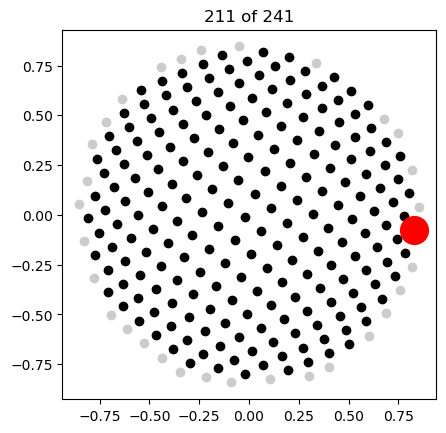

0.5915648294335567 -0.09183339294648643
<SkyCoord (AltAz: obstime=2023-03-08 01:45:26.431806, location=(1845655.49905341, -5270856.2947176, -3075330.77760682) m, pressure=0.0 hPa, temperature=0.0 deg_C, relative_humidity=0.0, obswl=1.0 micron): (az, alt) in deg
    (354.73833417, 33.89416803)>
<SkyCoord (ICRS): (ra, dec) in deg
    (115.91796496, 26.96035522)>
ra_h:dec_d 7.72786513388499:26.9602788489741
/data/lvm/spec/agcam/east/20230308/lvm.spec.agcam.east_00000248.fits
---------------------------------


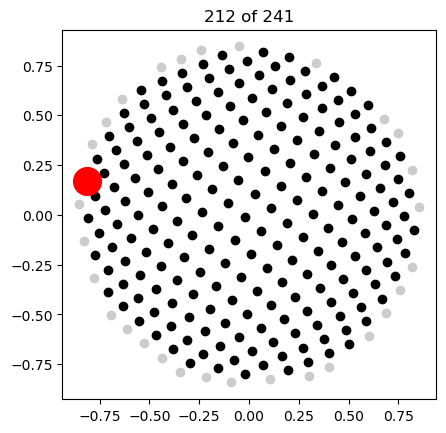

0.5907436558774912 2.938049448178801
<SkyCoord (AltAz: obstime=2023-03-08 01:45:43.901947, location=(1845655.49905341, -5270856.2947176, -3075330.77760682) m, pressure=0.0 hPa, temperature=0.0 deg_C, relative_humidity=0.0, obswl=1.0 micron): (az, alt) in deg
    (168.33783338, 33.84711826)>
<SkyCoord (ICRS): (ra, dec) in deg
    (181.99065489, -78.81523682)>
ra_h:dec_d 12.132722785618:-78.8152599728134
/data/lvm/spec/agcam/east/20230308/lvm.spec.agcam.east_00000249.fits
---------------------------------


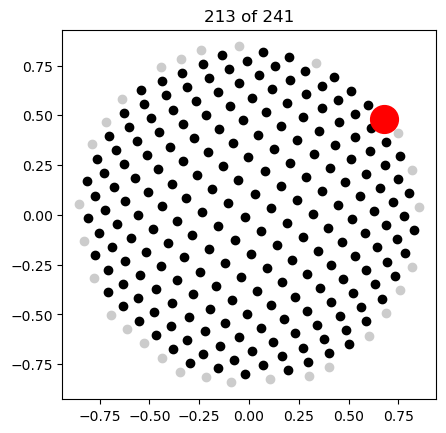

0.5907399142518989 0.6172549098215145
<SkyCoord (AltAz: obstime=2023-03-08 01:46:02.494365, location=(1845655.49905341, -5270856.2947176, -3075330.77760682) m, pressure=0.0 hPa, temperature=0.0 deg_C, relative_humidity=0.0, obswl=1.0 micron): (az, alt) in deg
    (35.36610122, 33.84690388)>
<SkyCoord (ICRS): (ra, dec) in deg
    (151.51902672, 18.91429884)>
ra_h:dec_d 10.1012716826567:18.9141811839898
/data/lvm/spec/agcam/east/20230308/lvm.spec.agcam.east_00000250.fits
---------------------------------


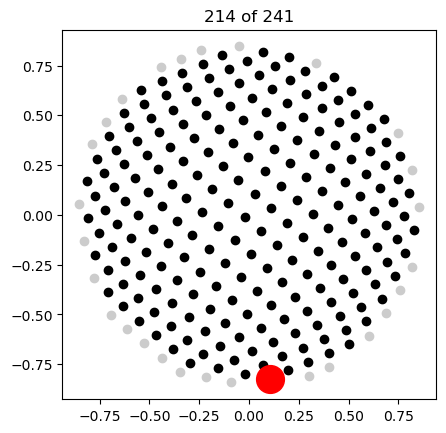

0.5890320919712173 -1.4441307659864024
<SkyCoord (AltAz: obstime=2023-03-08 01:46:20.405042, location=(1845655.49905341, -5270856.2947176, -3075330.77760682) m, pressure=0.0 hPa, temperature=0.0 deg_C, relative_humidity=0.0, obswl=1.0 micron): (az, alt) in deg
    (277.25740204, 33.74905287)>
<SkyCoord (ICRS): (ra, dec) in deg
    (64.1819693, -10.27855061)>
ra_h:dec_d 4.27879836718626:-10.278688901519
/data/lvm/spec/agcam/east/20230308/lvm.spec.agcam.east_00000251.fits
---------------------------------


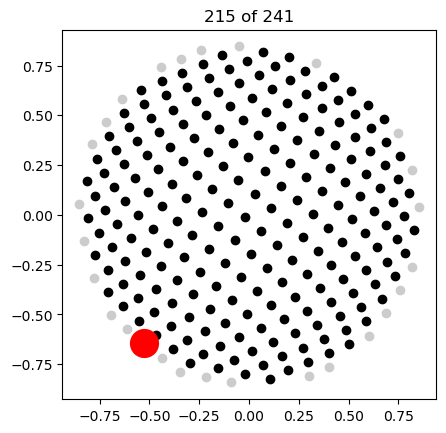

0.5858143703383712 -2.2554738468772433
<SkyCoord (AltAz: obstime=2023-03-08 01:46:38.411425, location=(1845655.49905341, -5270856.2947176, -3075330.77760682) m, pressure=0.0 hPa, temperature=0.0 deg_C, relative_humidity=0.0, obswl=1.0 micron): (az, alt) in deg
    (230.77086777, 33.564691)>
<SkyCoord (ICRS): (ra, dec) in deg
    (50.74351125, -46.87634701)>
ra_h:dec_d 3.38291010812752:-46.8762942548448
/data/lvm/spec/agcam/east/20230308/lvm.spec.agcam.east_00000252.fits
---------------------------------


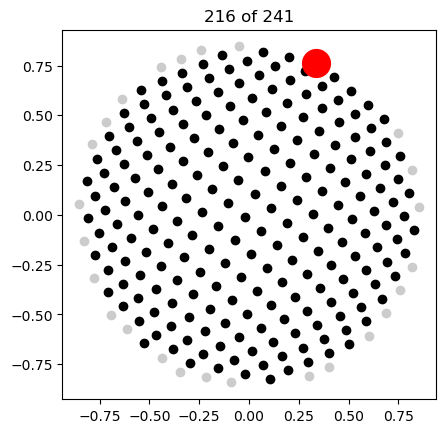

0.5812552259960257 1.1543367255027541
<SkyCoord (AltAz: obstime=2023-03-08 01:46:53.385004, location=(1845655.49905341, -5270856.2947176, -3075330.77760682) m, pressure=0.0 hPa, temperature=0.0 deg_C, relative_humidity=0.0, obswl=1.0 micron): (az, alt) in deg
    (66.13862251, 33.30347127)>
<SkyCoord (ICRS): (ra, dec) in deg
    (171.11258752, 1.81708452)>
ra_h:dec_d 11.4075098818918:1.81712944756829
/data/lvm/spec/agcam/east/20230308/lvm.spec.agcam.east_00000253.fits
---------------------------------


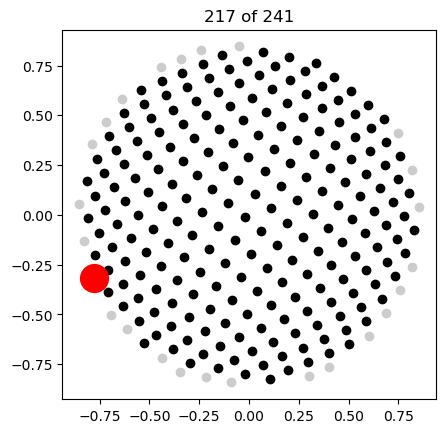

0.5764563324859151 -2.752508238688214
<SkyCoord (AltAz: obstime=2023-03-08 01:47:11.766272, location=(1845655.49905341, -5270856.2947176, -3075330.77760682) m, pressure=0.0 hPa, temperature=0.0 deg_C, relative_humidity=0.0, obswl=1.0 micron): (az, alt) in deg
    (202.29289485, 33.02851493)>
<SkyCoord (ICRS): (ra, dec) in deg
    (49.14426819, -70.59476883)>
ra_h:dec_d 3.27630515028024:-70.5947508939957
/data/lvm/spec/agcam/east/20230308/lvm.spec.agcam.east_00000254.fits
---------------------------------


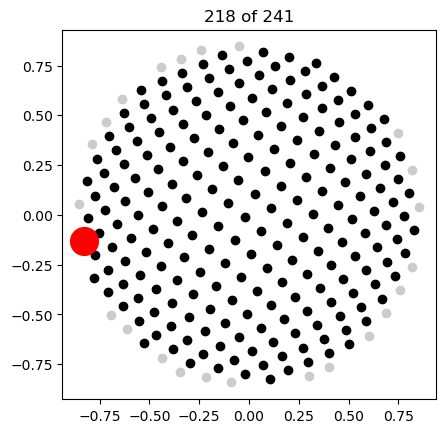

0.5751463868503288 -2.9831090322854203
<SkyCoord (AltAz: obstime=2023-03-08 01:47:22.104221, location=(1845655.49905341, -5270856.2947176, -3075330.77760682) m, pressure=0.0 hPa, temperature=0.0 deg_C, relative_humidity=0.0, obswl=1.0 micron): (az, alt) in deg
    (189.08044262, 32.95346057)>
<SkyCoord (ICRS): (ra, dec) in deg
    (61.28650186, -81.33308912)>
ra_h:dec_d 4.08574649021087:-81.3330665340209
/data/lvm/spec/agcam/east/20230308/lvm.spec.agcam.east_00000255.fits
---------------------------------


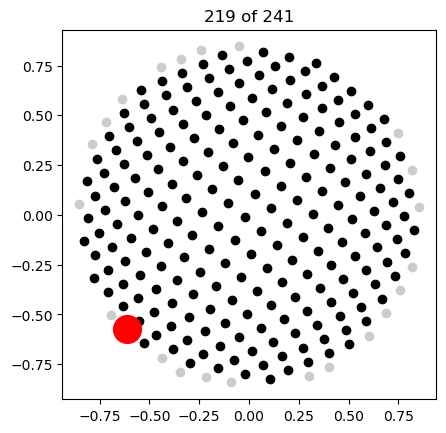

0.5749674625763662 -2.387482817164498
<SkyCoord (AltAz: obstime=2023-03-08 01:47:35.908891, location=(1845655.49905341, -5270856.2947176, -3075330.77760682) m, pressure=0.0 hPa, temperature=0.0 deg_C, relative_humidity=0.0, obswl=1.0 micron): (az, alt) in deg
    (223.20731092, 32.94320896)>
<SkyCoord (ICRS): (ra, dec) in deg
    (48.85551191, -53.08138516)>
ra_h:dec_d 3.25703989528267:-53.0813178345366
/data/lvm/spec/agcam/east/20230308/lvm.spec.agcam.east_00000256.fits
---------------------------------


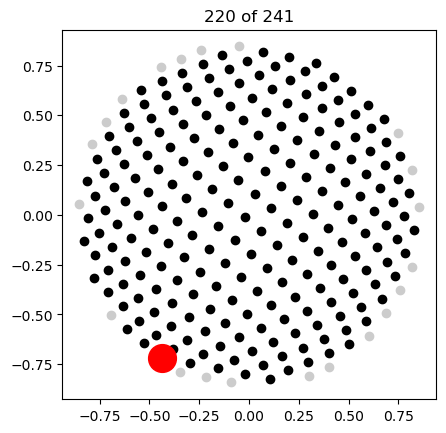

0.5740927203982111 -2.1196129968668576
<SkyCoord (AltAz: obstime=2023-03-08 01:47:50.806166, location=(1845655.49905341, -5270856.2947176, -3075330.77760682) m, pressure=0.0 hPa, temperature=0.0 deg_C, relative_humidity=0.0, obswl=1.0 micron): (az, alt) in deg
    (238.55512108, 32.89308993)>
<SkyCoord (ICRS): (ra, dec) in deg
    (51.69750543, -40.34858992)>
ra_h:dec_d 3.44649557799198:-40.348613646276
/data/lvm/spec/agcam/east/20230308/lvm.spec.agcam.east_00000257.fits
---------------------------------


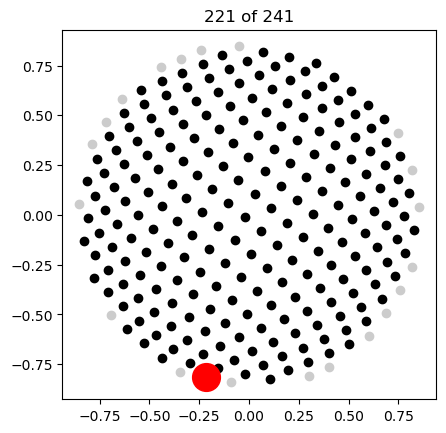

0.5692341765216915 -1.8290068697253168
<SkyCoord (AltAz: obstime=2023-03-08 01:48:04.111829, location=(1845655.49905341, -5270856.2947176, -3075330.77760682) m, pressure=0.0 hPa, temperature=0.0 deg_C, relative_humidity=0.0, obswl=1.0 micron): (az, alt) in deg
    (255.20562566, 32.61471587)>
<SkyCoord (ICRS): (ra, dec) in deg
    (55.85587239, -26.77724646)>
ra_h:dec_d 3.72372381372109:-26.7771680707764
/data/lvm/spec/agcam/east/20230308/lvm.spec.agcam.east_00000258.fits
---------------------------------


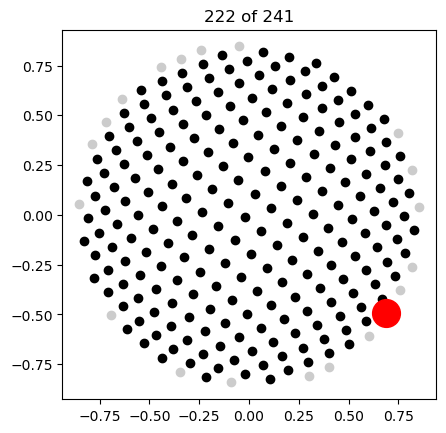

0.5667657395770956 -0.6213857359991737
<SkyCoord (AltAz: obstime=2023-03-08 01:48:17.586667, location=(1845655.49905341, -5270856.2947176, -3075330.77760682) m, pressure=0.0 hPa, temperature=0.0 deg_C, relative_humidity=0.0, obswl=1.0 micron): (az, alt) in deg
    (324.39721988, 32.47328485)>
<SkyCoord (ICRS): (ra, dec) in deg
    (90.06716465, 19.85091369)>
ra_h:dec_d 6.00448477506273:19.8510453693228
/data/lvm/spec/agcam/east/20230308/lvm.spec.agcam.east_00000259.fits
---------------------------------


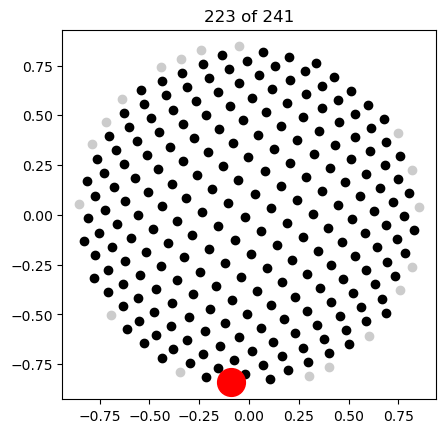

0.5622230300239158 -1.6747869423472257
<SkyCoord (AltAz: obstime=2023-03-08 01:48:26.337225, location=(1845655.49905341, -5270856.2947176, -3075330.77760682) m, pressure=0.0 hPa, temperature=0.0 deg_C, relative_humidity=0.0, obswl=1.0 micron): (az, alt) in deg
    (264.04177662, 32.21300677)>
<SkyCoord (ICRS): (ra, dec) in deg
    (58.39126191, -19.65410043)>
ra_h:dec_d 3.89274948733723:-19.654053813938
/data/lvm/spec/agcam/east/20230308/lvm.spec.agcam.east_00000260.fits
---------------------------------


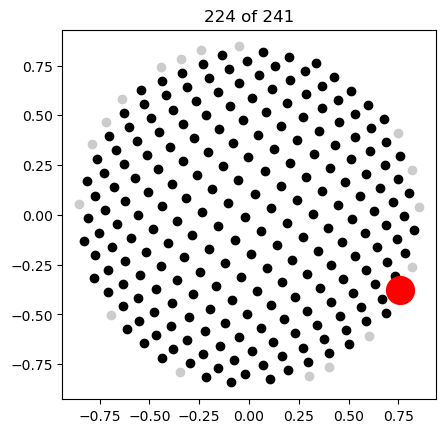

0.5621788226932143 -0.46107023980869594
<SkyCoord (AltAz: obstime=2023-03-08 01:48:41.905057, location=(1845655.49905341, -5270856.2947176, -3075330.77760682) m, pressure=0.0 hPa, temperature=0.0 deg_C, relative_humidity=0.0, obswl=1.0 micron): (az, alt) in deg
    (333.5826212, 32.21047387)>
<SkyCoord (ICRS): (ra, dec) in deg
    (97.33259944, 23.86009143)>
ra_h:dec_d 6.4888464072584:23.8602005632393
/data/lvm/spec/agcam/east/20230308/lvm.spec.agcam.east_00000261.fits
---------------------------------


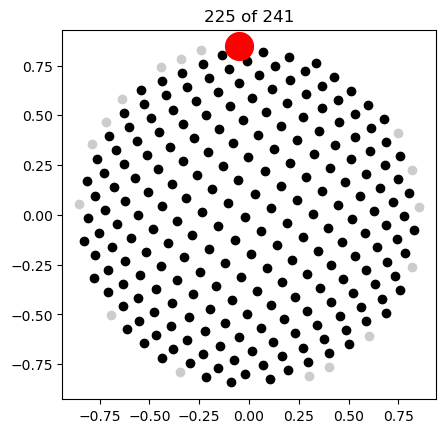

0.5599903352512194 1.6320249408007548
<SkyCoord (AltAz: obstime=2023-03-08 01:48:57.725092, location=(1845655.49905341, -5270856.2947176, -3075330.77760682) m, pressure=0.0 hPa, temperature=0.0 deg_C, relative_humidity=0.0, obswl=1.0 micron): (az, alt) in deg
    (93.50814117, 32.08508278)>
<SkyCoord (ICRS): (ra, dec) in deg
    (184.295485, -17.50189098)>
ra_h:dec_d 12.2863707859126:-17.5019554489081
/data/lvm/spec/agcam/east/20230308/lvm.spec.agcam.east_00000262.fits
---------------------------------


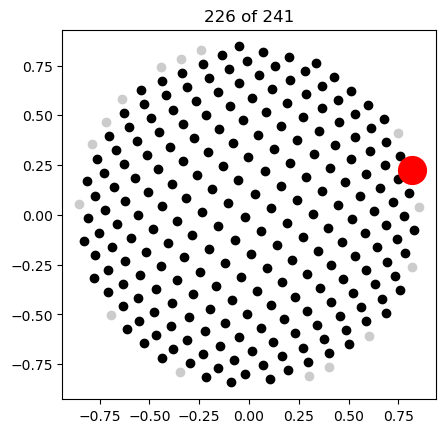

0.5576336495364073 0.2673934188933572
<SkyCoord (AltAz: obstime=2023-03-08 01:49:15.500988, location=(1845655.49905341, -5270856.2947176, -3075330.77760682) m, pressure=0.0 hPa, temperature=0.0 deg_C, relative_humidity=0.0, obswl=1.0 micron): (az, alt) in deg
    (15.32051437, 31.95005463)>
<SkyCoord (ICRS): (ra, dec) in deg
    (136.40057534, 27.42453599)>
ra_h:dec_d 9.09337308674067:27.4244416844473
/data/lvm/spec/agcam/east/20230308/lvm.spec.agcam.east_00000263.fits
---------------------------------


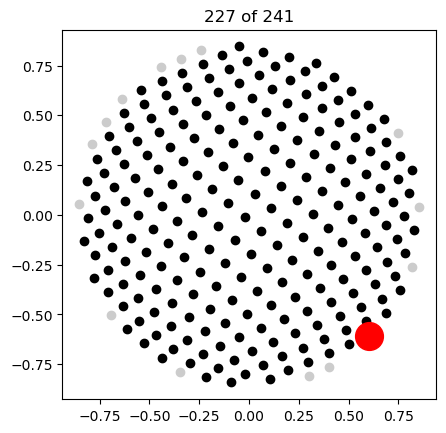

0.54887142002005 -0.7897122364972619
<SkyCoord (AltAz: obstime=2023-03-08 01:49:31.493269, location=(1845655.49905341, -5270856.2947176, -3075330.77760682) m, pressure=0.0 hPa, temperature=0.0 deg_C, relative_humidity=0.0, obswl=1.0 micron): (az, alt) in deg
    (314.75282182, 31.44801586)>
<SkyCoord (ICRS): (ra, dec) in deg
    (82.84122804, 15.78692665)>
ra_h:dec_d 5.52274977783827:15.7868181071213
/data/lvm/spec/agcam/east/20230308/lvm.spec.agcam.east_00000264.fits
---------------------------------


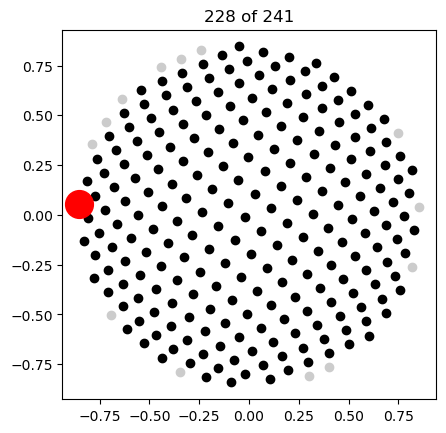

0.5484784120977776 3.079230405138253
<SkyCoord (AltAz: obstime=2023-03-08 01:49:48.298630, location=(1845655.49905341, -5270856.2947176, -3075330.77760682) m, pressure=0.0 hPa, temperature=0.0 deg_C, relative_humidity=0.0, obswl=1.0 micron): (az, alt) in deg
    (176.42690636, 31.42549817)>
<SkyCoord (ICRS): (ra, dec) in deg
    (173.14209545, -85.94988618)>
ra_h:dec_d 11.5427607406698:-85.9498214245559
/data/lvm/spec/agcam/east/20230308/lvm.spec.agcam.east_00000265.fits
---------------------------------


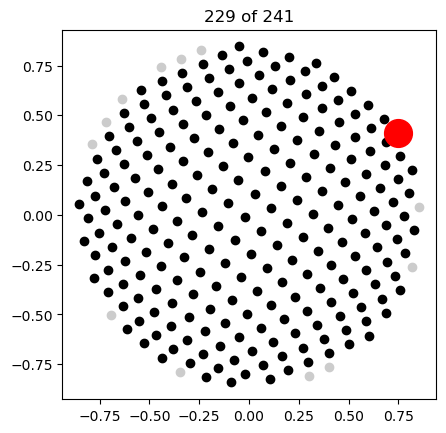

0.5459684434909648 0.500097211334084
<SkyCoord (AltAz: obstime=2023-03-08 01:50:06.182893, location=(1845655.49905341, -5270856.2947176, -3075330.77760682) m, pressure=0.0 hPa, temperature=0.0 deg_C, relative_humidity=0.0, obswl=1.0 micron): (az, alt) in deg
    (28.65345956, 31.28168756)>
<SkyCoord (ICRS): (ra, dec) in deg
    (148.62743816, 23.94772599)>
ra_h:dec_d 9.9085042019129:23.947590049921
/data/lvm/spec/agcam/east/20230308/lvm.spec.agcam.east_00000266.fits
---------------------------------


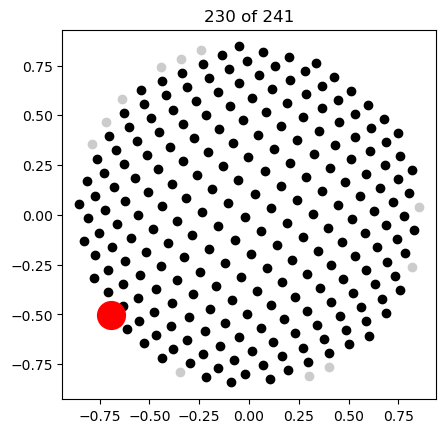

0.5453687710184815 -2.5116381937219354
<SkyCoord (AltAz: obstime=2023-03-08 01:50:24.601465, location=(1845655.49905341, -5270856.2947176, -3075330.77760682) m, pressure=0.0 hPa, temperature=0.0 deg_C, relative_humidity=0.0, obswl=1.0 micron): (az, alt) in deg
    (216.09373184, 31.24732886)>
<SkyCoord (ICRS): (ra, dec) in deg
    (45.5412289, -58.92434574)>
ra_h:dec_d 3.03609407604639:-58.9242710618339
/data/lvm/spec/agcam/east/20230308/lvm.spec.agcam.east_00000267.fits
---------------------------------


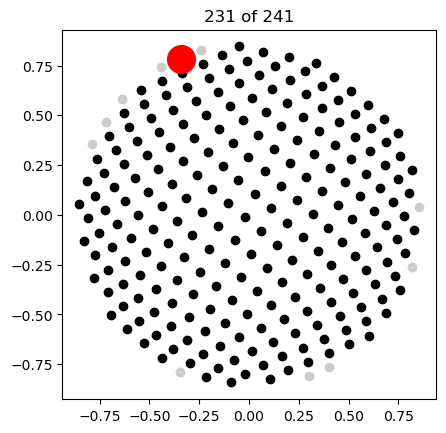

0.544016170059361 1.9794146846575922
<SkyCoord (AltAz: obstime=2023-03-08 01:50:42.136140, location=(1845655.49905341, -5270856.2947176, -3075330.77760682) m, pressure=0.0 hPa, temperature=0.0 deg_C, relative_humidity=0.0, obswl=1.0 micron): (az, alt) in deg
    (113.41210734, 31.16983053)>
<SkyCoord (ICRS): (ra, dec) in deg
    (192.04344508, -33.1241458)>
ra_h:dec_d 12.80290758533:-33.1241688082651
/data/lvm/spec/agcam/east/20230308/lvm.spec.agcam.east_00000268.fits
---------------------------------


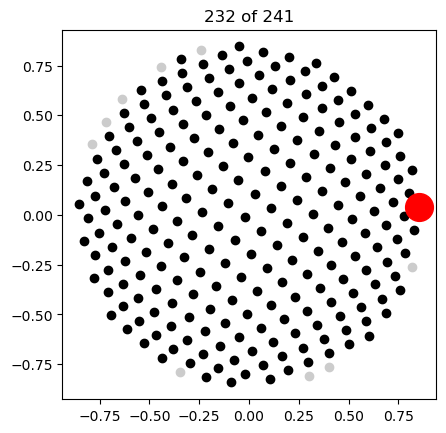

0.5419861245686464 0.04505141556906892
<SkyCoord (AltAz: obstime=2023-03-08 01:51:00.335733, location=(1845655.49905341, -5270856.2947176, -3075330.77760682) m, pressure=0.0 hPa, temperature=0.0 deg_C, relative_humidity=0.0, obswl=1.0 micron): (az, alt) in deg
    (2.58125597, 31.05351749)>
<SkyCoord (ICRS): (ra, dec) in deg
    (124.75747491, 29.96469273)>
ra_h:dec_d 8.31716409706208:29.9646346252287
/data/lvm/spec/agcam/east/20230308/lvm.spec.agcam.east_00000269.fits
---------------------------------


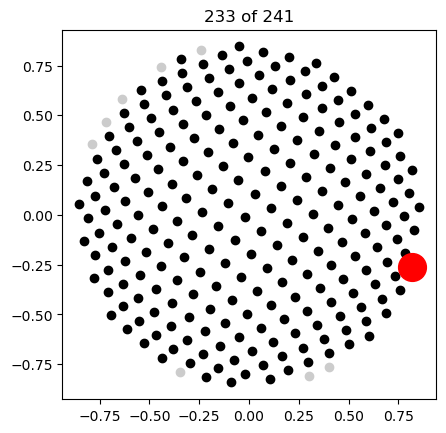

0.5401463100575578 -0.31012547405322727
<SkyCoord (AltAz: obstime=2023-03-08 01:51:17.403613, location=(1845655.49905341, -5270856.2947176, -3075330.77760682) m, pressure=0.0 hPa, temperature=0.0 deg_C, relative_humidity=0.0, obswl=1.0 micron): (az, alt) in deg
    (342.23111922, 30.94810389)>
<SkyCoord (ICRS): (ra, dec) in deg
    (105.08046717, 27.73856329)>
ra_h:dec_d 7.00536727136707:27.7385514555816
/data/lvm/spec/agcam/east/20230308/lvm.spec.agcam.east_00000270.fits
---------------------------------


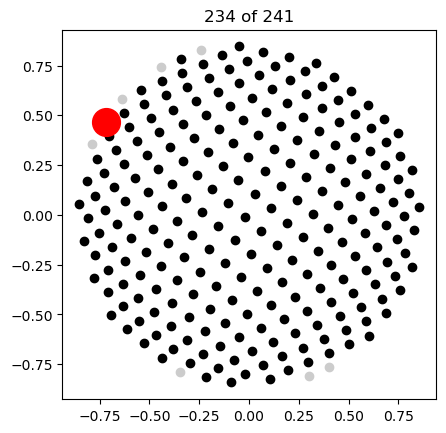

0.5391148685027076 2.5645126798637885
<SkyCoord (AltAz: obstime=2023-03-08 01:51:32.037860, location=(1845655.49905341, -5270856.2947176, -3075330.77760682) m, pressure=0.0 hPa, temperature=0.0 deg_C, relative_humidity=0.0, obswl=1.0 micron): (az, alt) in deg
    (146.93575306, 30.88900664)>
<SkyCoord (ICRS): (ra, dec) in deg
    (200.22807179, -61.27285799)>
ra_h:dec_d 13.3485554846964:-61.2728661948018
/data/lvm/spec/agcam/east/20230308/lvm.spec.agcam.east_00000271.fits
---------------------------------


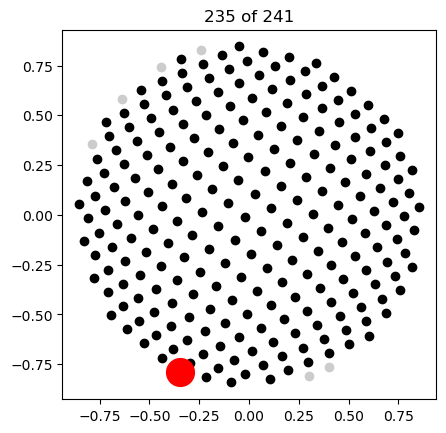

0.5354816316358422 -1.9850535126978353
<SkyCoord (AltAz: obstime=2023-03-08 01:51:50.131365, location=(1845655.49905341, -5270856.2947176, -3075330.77760682) m, pressure=0.0 hPa, temperature=0.0 deg_C, relative_humidity=0.0, obswl=1.0 micron): (az, alt) in deg
    (246.26481161, 30.6808375)>
<SkyCoord (ICRS): (ra, dec) in deg
    (52.02520222, -33.45353519)>
ra_h:dec_d 3.46835219350836:-33.4535620018145
/data/lvm/spec/agcam/east/20230308/lvm.spec.agcam.east_00000272.fits
---------------------------------


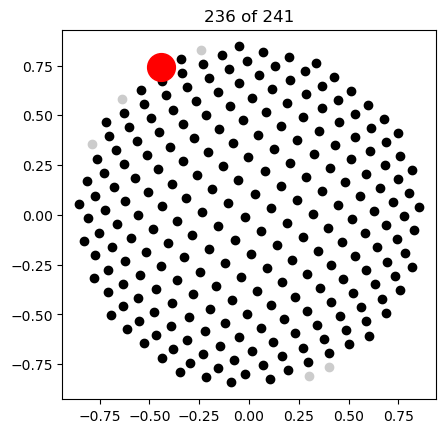

0.5314065150877647 2.106333354244688
<SkyCoord (AltAz: obstime=2023-03-08 01:52:08.205319, location=(1845655.49905341, -5270856.2947176, -3075330.77760682) m, pressure=0.0 hPa, temperature=0.0 deg_C, relative_humidity=0.0, obswl=1.0 micron): (az, alt) in deg
    (120.68401145, 30.44735052)>
<SkyCoord (ICRS): (ra, dec) in deg
    (195.29681047, -38.96013679)>
ra_h:dec_d 13.0197981422266:-38.9601976364451
/data/lvm/spec/agcam/east/20230308/lvm.spec.agcam.east_00000273.fits
---------------------------------


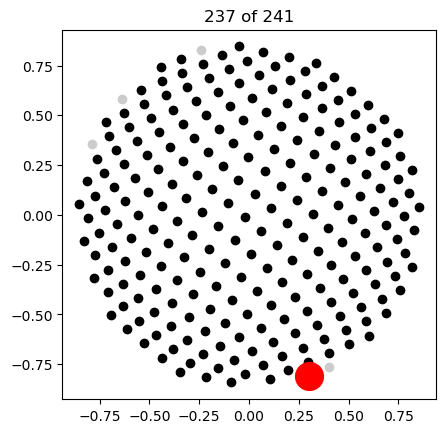

0.5306478843356696 -1.2139088916596723
<SkyCoord (AltAz: obstime=2023-03-08 01:52:26.921501, location=(1845655.49905341, -5270856.2947176, -3075330.77760682) m, pressure=0.0 hPa, temperature=0.0 deg_C, relative_humidity=0.0, obswl=1.0 micron): (az, alt) in deg
    (290.44814379, 30.40388418)>
<SkyCoord (ICRS): (ra, dec) in deg
    (68.7059708, 0.99357625)>
ra_h:dec_d 4.58040581373517:0.993670707598357
/data/lvm/spec/agcam/east/20230308/lvm.spec.agcam.east_00000274.fits
---------------------------------


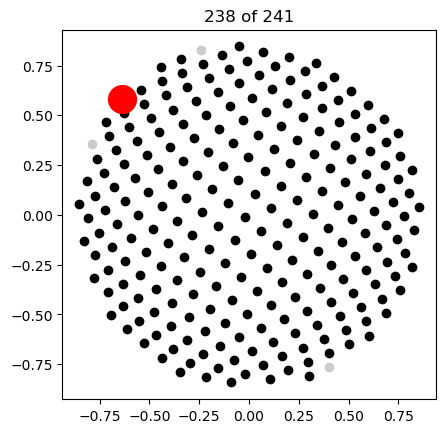

0.5296538498105565 2.4000215596433363
<SkyCoord (AltAz: obstime=2023-03-08 01:52:45.705394, location=(1845655.49905341, -5270856.2947176, -3075330.77760682) m, pressure=0.0 hPa, temperature=0.0 deg_C, relative_humidity=0.0, obswl=1.0 micron): (az, alt) in deg
    (137.51110611, 30.3469302)>
<SkyCoord (ICRS): (ra, dec) in deg
    (199.76659008, -53.15676142)>
ra_h:dec_d 13.3177829859508:-53.1568320165703
/data/lvm/spec/agcam/east/20230308/lvm.spec.agcam.east_00000275.fits
---------------------------------


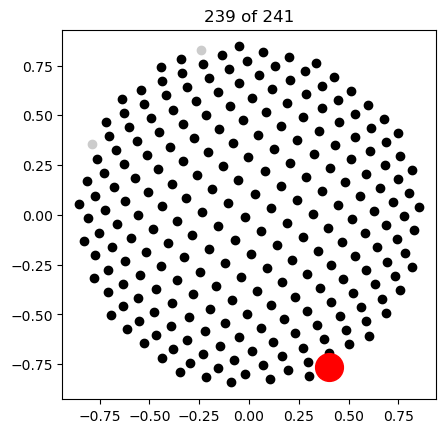

0.5295175168978008 -1.0878341540105976
<SkyCoord (AltAz: obstime=2023-03-08 01:53:04.910104, location=(1845655.49905341, -5270856.2947176, -3075330.77760682) m, pressure=0.0 hPa, temperature=0.0 deg_C, relative_humidity=0.0, obswl=1.0 micron): (az, alt) in deg
    (297.67169417, 30.3391189)>
<SkyCoord (ICRS): (ra, dec) in deg
    (72.54873944, 6.0249686)>
ra_h:dec_d 4.83659093814131:6.02501450885869
/data/lvm/spec/agcam/east/20230308/lvm.spec.agcam.east_00000276.fits
---------------------------------


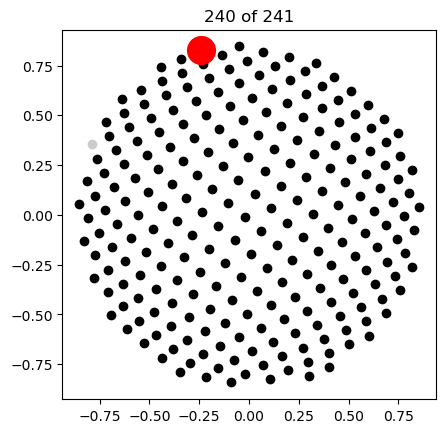

0.5284660301460635 1.8547960565626433
<SkyCoord (AltAz: obstime=2023-03-08 01:53:23.320229, location=(1845655.49905341, -5270856.2947176, -3075330.77760682) m, pressure=0.0 hPa, temperature=0.0 deg_C, relative_humidity=0.0, obswl=1.0 micron): (az, alt) in deg
    (106.2719859, 30.27887314)>
<SkyCoord (ICRS): (ra, dec) in deg
    (191.525896, -27.00900627)>
ra_h:dec_d 12.7684003452601:-27.0090450889991
/data/lvm/spec/agcam/east/20230308/lvm.spec.agcam.east_00000277.fits
---------------------------------


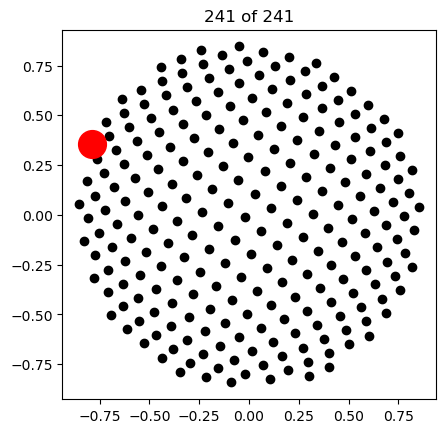

0.5280985884820611 2.7199649372001136
<SkyCoord (AltAz: obstime=2023-03-08 01:53:42.128830, location=(1845655.49905341, -5270856.2947176, -3075330.77760682) m, pressure=0.0 hPa, temperature=0.0 deg_C, relative_humidity=0.0, obswl=1.0 micron): (az, alt) in deg
    (155.84251133, 30.25782029)>
<SkyCoord (ICRS): (ra, dec) in deg
    (203.40103825, -68.8876025)>
ra_h:dec_d 13.5600806046952:-68.8876160438233
/data/lvm/spec/agcam/east/20230308/lvm.spec.agcam.east_00000278.fits
---------------------------------


In [12]:
# focus was set by routine
# now start the series over all points over the sky

show_2d_plot = True

# IF THE LOOP FAILED AT SOME POINT
# YOU CAN DEFINE HERE WHERE TO START FROM
# TO AVOID REDOING THE FIRST POINTS
start_from = 117


for index in range(len(alt)):
    if index<start_from-1:
        continue
    current_alt = alt[index]
    current_az = az[index]
    if show_2d_plot:
        fig,ax = plt.subplots()
        ax.set_aspect("equal")
        ax.plot(x[:index],y[:index],"ko")
        ax.plot(x[index:],y[index:],"o",color="0.8")
        ax.plot(x[index],y[index],"ro",ms=20)
        ax.set_title("{} of {}".format(index+1,len(alt)))
        plt.show()

    print(current_alt,current_az)
    
    
    observing_location = EarthLocation.of_site("Las Campanas Observatory")#(lat='52.2532', lon='351.63910339111703', height=100*u.m)  
    observing_time = Time.now()
    
    # on spec no km is present
    #await tel.km.slewStop()
    
    current_aa = SkyCoord(alt=current_alt*u.rad, az = current_az*u.rad, frame='altaz', obstime=Time.now(), location=observing_location)
    
    current_icrs = current_aa.transform_to(ICRS)
    print(current_aa)
    print(current_icrs)
    
    # lew telescope to ra/dec that is now where alt/az from list is
    rc = await tel.pwi.gotoRaDecJ2000(current_icrs.ra.hour,current_icrs.dec.deg)
    ra_h, dec_d = rc.flatten().unpack("ra_j2000_hours", "dec_j2000_degs")
    print(f"ra_h:dec_d {ra_h}:{dec_d}")

    # dont do that on every exposure if you didn't change the pointing
    
    # no km on spec
    #await tel.km.slewStart(ra_h, dec_d)
    
    #input("Telescope slewing done... proceed?")
    
    rc = await tel.agc.expose(7.)
    filenames = rc.flatten().unpack("*.filename")
    print(filenames)
    print("---------------------------------")

In [21]:
await tel.pwi.park() # goto park position
await tel.pwi.setEnabled(False) # disengage motors (telescope should be free floating now)

{'is_enabled': False,
 'axis0': {'is_enabled': False},
 'axis1': {'is_enabled': False}}